# סיווג סרטים באמצעות ניתוח סנטימנטלי
#### נכתב במסגרת פרויקט של סדנה במדעי הנתונים
**מגיש**: איתם יוגב

## הקדמה

המטרה שלי בפרוייקט היא ניתוח סנטימנטלי של סצנות סרטים, וניסיון לקישור בין רמות הסנטימנטים לאורך הסרט ובין סיווג הז'אנרים של הסרט. המשימה של סיווג סרטים לז'אנרים נראית פשוטה ממבט ראשון אך היא אינה טריוויאלית, שכן לא ניתן להסיק אותה באופן מיידי ממידע כלשהו על הסרט, והיא מצריכה ידע רחב ותושמת לב לדקויות. כמו כן, ז'אנר הוא אינו מאפיין בודד אחד, ובדרך כלל סרט יכול להשתייך לכמה ז'אנרים, וגם זה במידות שונות.

הרבה חברות סטרימינג גדולות כמו נטפליקס משתמשות בסיווג ז'אנרים כדי לזהות דמיון בין תכנים, וכך לתת למשתמש הצעות שיותר יתאימו לטעמו. קיימות שיטות רבות לסיווג ז'אנרים בעזרת למידת מכונה המשתמשות למשל בכותרת הסרט, תיאור הסרט טריילר ועוד.

בפרוייקט שלי אבחן את הרעיון של סנטימנטים במשפטים מתוך הסרט כבעלי קורלציה לז'אנרים והמאפיינים של הסרט. ניתוח התוכן עצמו של הסרט מאתגר יותר מאשר ניתוח נתונים נלווים, אך הוא מאפשר ניתוח מעמיק יותר והתייחסות לפרטים נוספים חשובים כמו ציר הזמן, הדמויות השונות, עוצמת הרגש וכו' מה שלא ניתן כאשר מנתחים למשל את התקציר של הסרט. בנוסף מציאת קורלציה בין סנטימנטים וז'אנרים יכולה לעבוד גם בכיוון ההפוך - בהינתן סרט בעל ז'אנר מסויים, תהיה אפשרות להגיד מהן התכונות של הדיאלוגים במהלך הסרט שעלינו לחפש בסרט מסוג זה.

### מגבלות

הרבה מהדיאלוגים בסרט הם בעלי סאבטקסט וטונים שלא ניתן לחלץ מתוך הטקסט לבדו, למשל:
- סנטימנטים שמומחשים במהלך הסרט בעזרת ויזואליות, אטמוספירה ומוזיקה שנותנות את האפקט של מתח, אימה, קומדיה וכו'.
- משפטים ציניים הנאמרים בצורה ניטרלית לכאורה אך בעצם מאפיינים סרטי קומדיה 
- משפטים שמקבלים משמעות כפולה בהקשרים שונים 
לכן מבחינה עקרונית חילוץ מידע על הז'אנר של הסרט רק בעזרת התסריט הוא מוגבל במידה מסוימת ולא יכול להיות חף מטעויות. למרות זאת, באופן כללי ניתן לחלץ את המשמעות מתוך הטקסט למרות האפטים הנלווים, ומשמעות כפולה במשפטים היא לא נפוצה.

בנוסף, תסריט של סרט הוא טקסט ארוך שמכיל הרבה שיחות ומונולוגים בין הדמויות, ואיחוד המידע על השיחות הללו לכדי מאפיינים בודדים של הסרט היא משימה לא טריוויאלית. במהלך הפרויקט אתמודד עם בעיה זו בעזרת פתרונות שונים.

## נתונים

### המאגר

מאגר הנתונים שבחרתי עבור הפרויקט הוא מאגר דיאלוגים בסרטים של אוניב' קורנל, שנמצא ב- 
[Kaggle](https://www.kaggle.com/datasets/Cornell-University/movie-dialog-corpus)

המאגר מכיל מידע טקסטואלי שחולץ מ-617 תסריטי סרטים באנגלית, ו-304,713 משפטים שנאמרו בסרטים. עבור כל סרט הוא מכיל מידע על השורות שנאמרו, אילו שורות שייכות לאותו דיאלוג או שיחה בסרט, על ידי מי נאמרה השורה ומיהן הדמויות בסרט. כמו כן לכל סרט יש מידע שנלקח מIMDB המכיל גם את הז'אנרים.

נבצע טעינה של הטבלאות ל-DataFrames של pandas.

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [91]:
meta_cols = ['movie_id', 'title', 'year', 'rating', 'no. votes', 'genres']
meta = pd.read_table(
    './datasets/movie-dialog-corpus/movie_titles_metadata.tsv', sep='\t', header=None, names=meta_cols, index_col='movie_id')

In [92]:
meta.sample(5)

,title,year,rating,no. votes,genres
movie_id,,,,,
m198,star trek: nemesis,2002,6.4,28682,['action' 'sci-fi' 'thriller']
m232,the abyss,1989,7.6,51699,['action' 'adventure' 'drama' 'sci-fi' 'thrill...
m55,eternal sunshine of the spotless mind,2004,8.5,224838,['drama' 'romance' 'sci-fi']
m256,barton fink,1991,7.8,33119,['drama' 'mystery' 'thriller']
m360,jason lives: friday the 13th part vi,1986,5.3,9919,['comedy' 'horror' 'thriller']


עבור הטבלאות movie_lines ו-movie_conversations, מבחינה ראשונית נראה שיש שורות בפורמט לא תקין. בחרתי לוותר על שורות אלו (עם `on_bad_lines=skip`). 

In [93]:
line_cols = ['line_id', 'character_id', 'movie_id', 'character_name', 'text']
lines = pd.read_table('./datasets/movie-dialog-corpus/movie_lines.tsv', sep='\t',
                      header=None, names=line_cols, index_col='line_id', on_bad_lines='skip')

conv_cols = ['first_char', 'second_char', 'movie_id', 'line_ids']
convos = pd.read_table(
    './datasets/movie-dialog-corpus/movie_conversations.tsv', sep='\t', header=None, names=conv_cols, on_bad_lines='skip')

### עיבוד מקדים

בטבלת הסרטים (meta) עמודת הז'אנרים היא string מהצורה ['comedy' 'musical']. נמיר את הנתונים בעמודה ל-list: 

In [94]:
def str_to_list(str: str):
    s = str.strip('\'[]')
    return list(set(s.split("\' \'") if s else []))

meta['genre_list'] = meta.genres.apply(str_to_list)

אם נבחן את את טיב הנתונים בטבלת השורות, נראה כי קיימות שורות לא תקינות. למשל:
- שורות ריקות
- שורות עם תיאור שנלקח מהתסריט, שאינו חלק מהשורה
- שורות עם סימני HTML
- שורות עם סימנים רנדומליים
- שורות המכילות תווים לא מוכרים, נובע מהבדלים ב-encoding

In [95]:
print(lines.loc['L24609'].text)
print(lines.loc['L265057'].text)
print(lines.loc['L55857'].text)
print(lines.loc['L545466'].text)
print(lines.loc['L523286'].text)

nan
I think that's... {HE STARTS TO RISE AND THE MEETING BEGINS TO BREAK UP) Starling I'm sure these gentlemen...
And his 'egghead' son!  We'll give 'em a <u>rough</u> <u>reception</u> won't we?
An anti-matter discharge directly ahead=8A it might disrupt the field long enough for us to break away.
You know what? Im not having this conversation right now.


לכן ראשית נצטרך לבצע preprocessing כדי לטייב את הטקסטים. אם נעבור על הטקסטים בעזר ביטוי רגולרי, נמצא כי קיימים מספר סימנים חריגים:

In [96]:
import re

def invalid_chars(txt):
    match = re.search("([^\w\s\d!?.,'\"-:;])", txt)
    return list(match.groups()) if match else []

matches = lines.dropna().text.apply(invalid_chars)
matches[matches.apply(lambda x : len(x) > 0)].explode().unique()

array(['<', '`', '\xad', '\x97', '[', '\x96', '~', '^', '=', '\x82',
       '\x93', '\x92', '|', '{', '\x91', ']', '\x8a', '>', '\x8c', '˛'],
      dtype=object)

רוב הסימנים המתחילים ב-x\ הם סימנים שנאבדו בגלל בעיית encoding, כולל כמה מופעים של =. נתקן את מה שנוכל, ומהשאר נתעלם: 

In [97]:
import re

def fix_windows_encoding(match):
    return match.group(0).encode('utf-8')[1:].decode('cp1252')

def preprocess_text(text):
    # fix encoding
    text = re.sub('[\x97\x96\x82\x93\x92\x91]', fix_windows_encoding, text)
    text = re.sub('=\w+ ', ' ', text)
    
    # remove html symbols
    text = re.sub('<.+>', ' ', text)
    text = re.sub('&[a-z]+;', ' ', text)
    
    # remove transcripts
    text = re.sub('{.+\)', ' ', text)
    
    # ignore everything else
    return re.sub('[^\w\s\d!?.,\'"-:;—’“‚–`˛‘’]', '', text)

lines = lines.dropna()
lines['text_pp'] = lines.text.apply(preprocess_text)

In [98]:
print(lines.loc['L265057'].text_pp)
print(lines.loc['L55857'].text_pp)
print(lines.loc['L545466'].text_pp)
print(lines.loc['L523286'].text_pp)

I think that's...   Starling I'm sure these gentlemen...
And his 'egghead' son!  We'll give 'em a   won't we?
An anti-matter discharge directly ahead it might disrupt the field long enough for us to break away.
You know what? I’m not having this conversation right now.


## EDA

### ניתוח נתונים כללי 

ראשית נבדוק את טווח השנים של הסרטים שנמצאים במאגר:

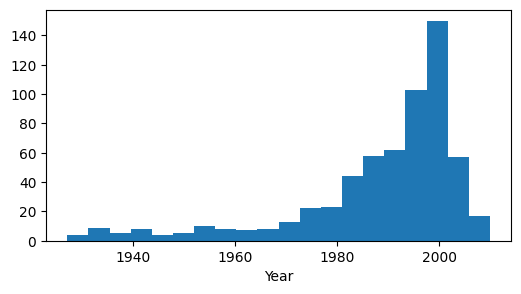

In [99]:
years = meta.year.apply(lambda y : int(y.split('/')[0]))
plt.figure(figsize=(6,3))
plt.hist(years, bins=20)
plt.xlabel('Year')
plt.show()

נראה כי רוב הסרטים הם משנות ה90, קצת לא מעודכן, אך זאת לא עובדה שאמורה להשפיע בהמשך. 

ננתח את פיזור כמות השיחות בכל סרט מאגר:

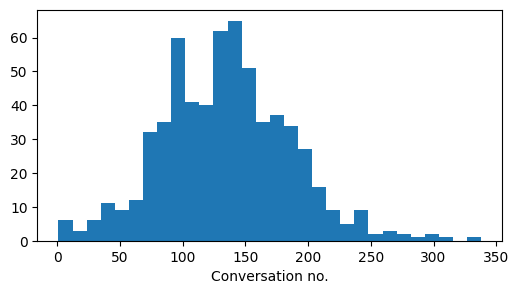

In [100]:
plt.figure(figsize=(6,3))
plt.hist(convos.movie_id.value_counts(), bins=30)
plt.xlabel('Conversation no.')
plt.show()

מפיזור כמויות השיחות בסרטים ניתן ללמוד כי מספר השיחות בכל סרט משתנה, וכי ברוב הסרטים יש בין 100 ל-200 שיחות. כמו כן נראה שיש סרטים עם מספר שיחות קטן מאוד (< 50), כלומר המידע לגביהם חסר או לא רלוונטי. נצטרך להתחשב בפערים אלו כאשר נבצע עיבוד לנתונים בהמשך.

כעת נבחן את פיזור הז'אנרים המשויכים לסרטים:

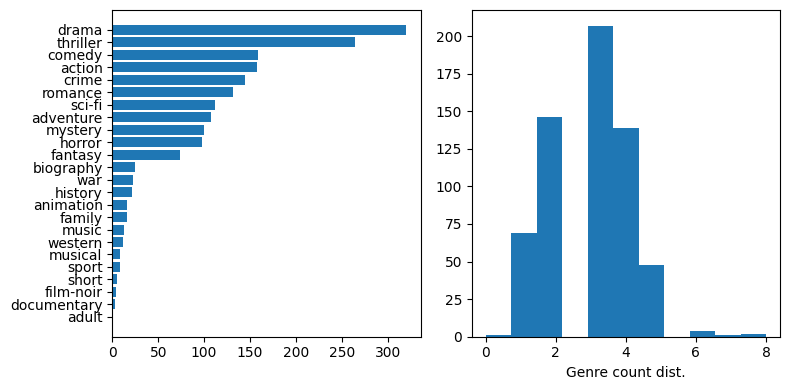

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)

genre_counts = meta.explode('genre_list').genre_list.value_counts()

axes[0].barh(genre_counts.index, genre_counts.values)
axes[0].invert_yaxis()

axes[1].hist(meta.genre_list.apply(len), bins=11)
axes[1].set_xlabel('Genre count dist.')

plt.show()

הגרף משמאל מראה את כמות הסרטים בכל ז'אנר, והגרף מימין מראה את פיזור כמות הז'אנרים המשוייכים לכל סרט. מגרפים אלו ניתן ללמוד כמה דברים:
1. קיימים הבדלים מהותיים בין שלושה קבוצות של ז'אנרים:
    - דרמה ומתח הם הז'אנרים הפופולריים ביותר, ושניהם נמצאים במספר גדול מאוד של סרטים. עובדה זו הגיונית כיוון שדרמה ומתח הם כלליים יותר משאר הז'אנרים, אך ייתכן וכלליות זו תפגע ביכולת שלנו לסווג את הסרטים בצורה מדויקת בהמשך.
    - הקבוצה השנייה היא קבוצת הז'אנרים הסטנדרטית (אקשן, קומדיה וכו') שרוב הסרטים משוייכים לאחד מהז'אנרים בה
    - הקבוצה השלישית היא קבוצת ז'אנרים המינורים, שהם יותר ספציפיים ולא משותפים למספר גדול של סרטים. מקבוצה זו ככל הנראה נתעלם כאשר נרצה לאמן מודל לסיווג ז'אנרים.
2. רוב הסרטים משוייכים ל-3-5 ז'אנרים, אך קיימים סרטים שלהם 6-8 ז'אנרים או ז'אנר אחד.
    - מיעוט בז'אנרים יכול להביא לתוצאות פחות מדויקות, ומדובר בפער הקיים במאגר הנתונים (בפועל לסרטים אלו יש ז'אנרים נוספים) 
    - ריבוי ז'אנרים יכול להיות טוב, אך בפועל הז'אנרים הנוספים כנראה הם כאלו מינוריים שפחות מאפיינים באופן מהותי את הסרט, ולכן פחות רלוונטיים. 

### ניתוח טקסטואלי בסיסי 

כדי לנתח את הטקסטים בטבלת lines, נגדיר ראשית פונקציות עזר שישמשו לביצוע tokenization עם התעלמות מ-stopwords: 

In [102]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

STOP_WORDS = set(stopwords.words('english'))

def is_word(string: str):
    return string.isalpha() and string.lower() not in STOP_WORDS

def tokenize(text):
    return [w for w in word_tokenize(text) if is_word(w)]

ננתח את המילים שמופיעות בסרטים השייכים לשני ז'אנרים, קומדיה ופשע. כדי לעשות זאת נבחר באקראי 10 סרטים מכל ז'אנר, ונאחד אותם לכדי טקסט יחיד:

In [103]:
from nltk.text import Text

def sample_genre(genre, n):
    return meta[meta.genre_list.apply(lambda x: genre in x)].sample(n, random_state=0)

def genre_tokens(genre, n):
    movies = sample_genre(genre, n)
    print(genre)
    print(movies.title.to_list())
    return tokenize(' '.join(lines.join(movies, on="movie_id", how="inner").text_pp))

crime_text = Text(genre_tokens('crime', 10))
comedy_text = Text(genre_tokens('comedy', 10))

crime
['basic', 'léon', 'made', 'cellular', 'crash', 'hostage', 'bones', 'kalifornia', 'on the waterfront', 'minority report']
comedy
['birthday girl', 'monkeybone', 'the fisher king', 'ninotchka', 'man on the moon', 'peggy sue got married', 'swingers', 'shakespeare in love', 'legally blonde', 'charade']


נציג את התפלגות המילים בטקסטים בעזרת WordCloud: 

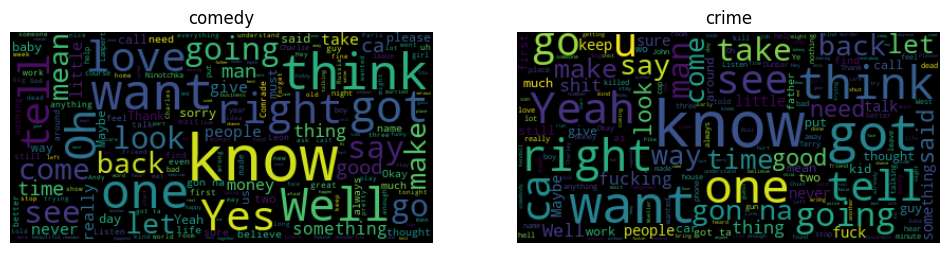

In [104]:
from wordcloud import WordCloud

plt.subplots(1, 2, figsize=(12, 5))
plt.subplot(121)
plt.title("comedy")
wordcloud = WordCloud(max_font_size=60).generate(' '.join(comedy_text.tokens)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")

plt.subplot(122)
plt.title("crime")
wordcloud = WordCloud(max_font_size=60).generate(' '.join(crime_text.tokens)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 

plt.show()

הרבה מהמילים בשני הטקסטים הפופולריות ביותר הן זהות כמו know, think, want, שכן הם מילים יומיומיות שכחיות. לעומת זאת קיימות מילים אחרות ייחודיות לכל ז'אנר, למשל love בז'אנר קומדיה, ומילים גסות יותר שמופיעות יותר בסרטי פשע. הבדל זה הגיוני כיוון שבכל ז'אנר השיחות הן בדרך כלל על נושאים ועם סגנונות שונים.

נבדוק את התדירות הצבורה של המילים בטקסטים:

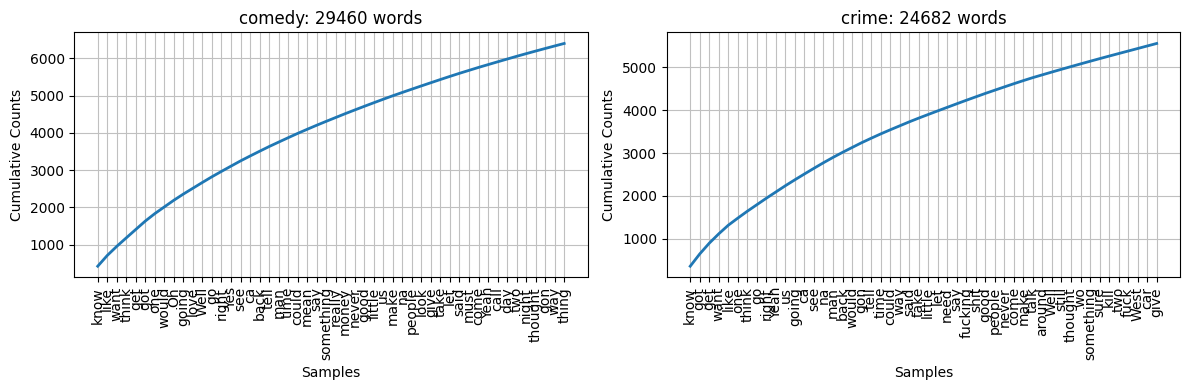

In [105]:
from nltk import FreqDist

plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(121)
ax = FreqDist(comedy_text).plot(50, cumulative=True, show=False)
ax.set_title("comedy: {} words".format(len(comedy_text.tokens)))

plt.subplot(122)
ax = FreqDist(crime_text).plot(50, cumulative=True, show=False)
ax.set_title("crime: {} words".format(len(crime_text.tokens)))

plt.tight_layout()
plt.show()

על פי הגרפים נראה שה-50 המילים הנפוצות ביותר תופסות בכל ז'אנר בערך 20% מסך המילים. זהו מספר נמוך יחסית, מה שמצביע על עושר לקסיקלי גבוה בסרטים. 

כמו כן, אם נבחן את המילים שמופיעות פעם אחת בטקסטים, נגלה מילים בקומדיה שהם בדרך כלל יותר חיוביות מאשר פשע:

In [106]:
print(FreqDist(comedy_text).hapaxes()[:10])
print(FreqDist(crime_text).hapaxes()[:10])

['coke', 'cans', 'wrappers', 'dustbins', 'clever', 'guitar', 'presents', 'friendship', 'Hard', 'Cafe']
['noon', 'slept', 'quadruple', 'negative', 'matters', 'explains', 'unaccounted', 'bite', 'tongue', 'bayou']


### עושר לקסיקלי 

נבחן את רמת העושר הלקסיקלי לאורך הסרטים. קיימות דרכים רבות לבדוק עושר לקסיקלי, למטרתנו נבחר את MSTTR (Mean Segmental TTR) שהוא היחס בין כמות המילים הייחודיות וכמות המילים בכלל, וזאת לפי ממוצע בחלוקה לקטעים. היתרון בכך הוא אחידות גבוהה יותר בתוצאה בניתוח טקסטים באורכים שונים.

ננתח את העושר הלקסיקלי הממוצע עבור כל סרט, ונציג אותם בגרף פיזור לפי ז'אנר:

In [107]:
from lexical_diversity import lex_div as ld

def lexical_diversity(text):
    return ld.msttr(tokenize(text), window_length=100)

movie_texts = lines[['movie_id', 'text_pp']].groupby('movie_id').agg(lambda texts: ' '.join(texts))
movie_ld = pd.Series([lexical_diversity(movie_texts.iloc[i].text_pp) for i in tqdm(range(len(movie_texts)))], index=movie_texts.index)

  0%|          | 0/617 [00:00<?, ?it/s]

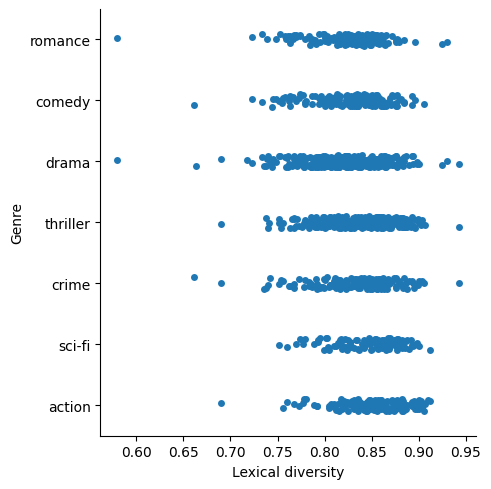

In [108]:
genre_lds = movie_ld.to_frame('ld').join(meta.explode('genre_list').genre_list, on="movie_id", how="inner")
top_genres = meta.explode('genre_list').genre_list.value_counts().nlargest(7).index
tio_genre_lds = genre_lds[genre_lds.genre_list.apply(lambda x: x in top_genres)]
g = sns.catplot(data=tio_genre_lds, x="ld", y="genre_list")
g.set_axis_labels("Lexical diversity", "Genre")

מהגרף נראה כי העושר הלקסיקלי הוא מאפיין יציב יחסית בכל הסרטים, מלבד חריגות בודדות, אך לא נראה שיש הבדל בין הז'אנרים בעושר הלקסיקלי, לפחות לא מבחינת הממוצע בכל סרט.

## סיווג בעזרת ניתוח סנטימנטלי

### אלגוריתם ניתוח סנטימנטלי

כפי שהזכרתי, המרכיב המרכזי שברצוננו לבחון הוא הקשר בין עוצמת הסנטימנטים לאורך סרט לבין הז'אנרים שלו. כדי לחלץ את המידע על הסנטימנטים מתוך הטקסט, נשתמש באלגוריתם ניתוח סנטימנטלי המבוסס על NLP. קיים מגוון רחב של אלגוריתמים שמבצעים משימה זו, אך האלגוריתם צריך לענות על כמה תנאים:
- האלגוריתם צריך להתמודד עם משפטים מורכבים הכוללים שלילה, שאלות וכו'. אלגוריתמים של למידה מפוקחת כמו אלו המסתמכים על מילה או מילים ספציפיות, לא יתנו מענה טוב כיוון שהם פשוטים ולא יעמדו בניואנסים של דיאלוג בסרט.
- האלגוריתם צריך לנתח מספר סנטימנטים, ולתת יותר מידע מחיובי/שלילי. זאת כדי לתת מענה לסיווג הז'אנרים נדרשת כמות גדולה יותר של פיצ'רים.
- האלגוריתם צריך להיות בצורת מודל מאומן, כיוון שהמידע שברשותנו לא מאפשר אימון מודל חדש עבור ניתוח סנטימנטלי.

לפיכך לשם ביצוע המשימה נבחר במודל ציבורי שאומן מראש מאתר [hugging-face 🤗](https://huggingface.co/), או ספציפית ב-[j-hartmann/emotion-english-distilroberta-base](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base). 

המודל מבוסס על מודל השפה DistilRoBERTa, שהוא גלגול של מודל השפה BERT המבוסס על transformers, שהם כלי מרכזי במשימות ניתוח טקסט. DistilRoBERTa הוא שיפור של BERT גם מבחינת ביצועים, וגם מבחינת כמות המידע שעליו המודל אומן.

השימוש במודל נעשה בעזרת ממשק ה-pipeline של 🤗 עם המשימה text-classification: 

In [109]:
from transformers import pipeline

classifier = pipeline("text-classification",
                      model="j-hartmann/emotion-english-distilroberta-base", top_k=None)

המודל מאפשר לתייג מידע טקסטואלי באנגלית בעזרת 6 רגשות שונים, ובפרט קבוצת הרגשות האוניברסליים של [אקמן](https://www.paulekman.com/universal-emotions/):
כעס, פחד, עצב, שמחה, הפתעה וגועל, וכן גם הרגש הניטרלי.

המודל מקבל כקלט משפט או טקסט קצר כלשהו, ומחזיר רשימה שבה עבור כל רגש שהוזכר למעלה מוצמד שבר עשרוני, שאומר עד כמה הטקסט מתאים לאותו רגש:

In [110]:
classifier("I don't feel like going out today")

[[{'label': 'sadness', 'score': 0.9483489394187927},
  {'label': 'neutral', 'score': 0.021178126335144043},
  {'label': 'disgust', 'score': 0.014277932234108448},
  {'label': 'fear', 'score': 0.006514255423098803},
  {'label': 'surprise', 'score': 0.004534238949418068},
  {'label': 'anger', 'score': 0.002661176258698106},
  {'label': 'joy', 'score': 0.0024853565264493227}]]

המודל יודע להתמודד עם הרבה ניואנסים סמנטיים, ויש לו רמת דיוק גבוהה מאוד. אמנם עדיין קיימים משפטים שמשמעותם תלויה בהקשר שבו הם נאמרו, למשל המשפט: 

In [111]:
classifier("Are you serious!?")

[[{'label': 'surprise', 'score': 0.4399447739124298},
  {'label': 'anger', 'score': 0.397427499294281},
  {'label': 'disgust', 'score': 0.09223880618810654},
  {'label': 'neutral', 'score': 0.027384191751480103},
  {'label': 'sadness', 'score': 0.024068422615528107},
  {'label': 'fear', 'score': 0.012041479349136353},
  {'label': 'joy', 'score': 0.006894752848893404}]]

מקבל רגש שונה בנסיבות שונות, וכפי שניתן לראות בתוצאה, גם המודל מכיר בכך. אנו מניחים כי משפטים אלו זניחים ביחס למשפטים האחרים שהם כן חד-משמעיים ויתרמו יותר למידע הסנטימנטלי בסרט. 

### חלוקה לדיאלוגים 

לא ניתן לבצע ניתוח סנטימנטלי ראליסטי לתוכנו של הסרט ללא חלוקה כלשהי, שכן ניתוח של הסרט בשלמותו הוא ארוך מדי ודורש מודל מסוג אחר, וכן מאבד את מימד הזמן. מצד שני ניתוח בנפרד של כל משפט בסרט יכול לקחת הרבה זמן. לכן החלוקה של סרט לדיאלוגים/שיחות כפי שנמצאת במאגר מתאימה למטרתנו. כמו כן, הגבלת אורך הטקסט תצמצם את מרווח הטעייה של המודל ותחזק את תוצאת הניתוח.

למרות החלוקה לשיחות שנמצאת בטבלה convos, עדיין עלינו להגביל את אורך הטקסט שאנו מעבירים למודל, כיוון שהמודל מוגבל למספר מסויים של קלטים. ניתן לקבל את מספר זה מתוך ה-tokenizer של המודל:

In [112]:
classifier.tokenizer.max_len_single_sentence

510

כדי להתמודד עם ההגבלה הזו, נחלק את שורות הסרטים לדיאלוגים. המטרה בחלוקה היא ליצור טקסטים בדידים קוהרנטים באורך מתאים, שיש להם מכנה משותף (שייכים לאותה שיחה).
נעשה זאת באופן הבא:
- כל שיחה תחשב כדיאלוג אחד לפחות
- אם אורך השיחה גדול מהאורך המותר, נחלק את השיחה לתת-שיחות לפי שורות, כך שכל תת-שיחה היא באורך המותר
- במקרה הקיצון ששורה ארוכה מדי, נקצץ את השורה. 

קיצוץ השורות הוא לא אופטימלי כיוון שהוא מאבד מידע, אבל ההנחה היא שכל שורה היא בעלת סנטימנטים יחסית אחידים, ולכן חלק ממנה בד"כ משליך על כולה.  

In [29]:
max_length = classifier.tokenizer.max_len_single_sentence
missing_lines = 0

def get_line_groups(lines: list[str]):
    curr_group = None
    for line in lines:
        if not curr_group:
            curr_group = line
        elif (len(curr_group) + len(line)) > max_length:
            yield curr_group
            curr_group = None
        else:
            curr_group = ' '.join([curr_group, line])
    if curr_group:
        yield curr_group

def get_lines_text(row):
    global missing_lines
    line_texts = []
    for id in str_to_list(row['line_ids']):
        if id not in lines.index:
            missing_lines += 1
            continue
        line = lines.loc[id].text_pp
        if len(line) > max_length:
            line = line[:max_length]
        line_texts.append(line)
    if sum([len(s) for s in line_texts]) <= max_length:
        return [' '.join(line_texts)]
    return get_line_groups(line_texts)

def get_dialog_texts():
    for i in range(len(convos)):
        convo = convos.iloc[i]
        texts = get_lines_text(convo)
        if not texts:
            continue
        for text in texts:
            yield {
                'first_char': convo.first_char,
                'second_char': convo.second_char,
                'movie_id': convo.movie_id,
                'text': text
            }
            
dialog_texts = pd.DataFrame(get_dialog_texts())
print('missing lines:', missing_lines)
dialog_texts.shape

missing lines: 459


(88091, 4)

אם נבדוק את פיזור כמות הטקסטים שנוצרו נקבל כי ההתפלגות דומה להתפלגות השיחות שקיבלנו למעלה: 

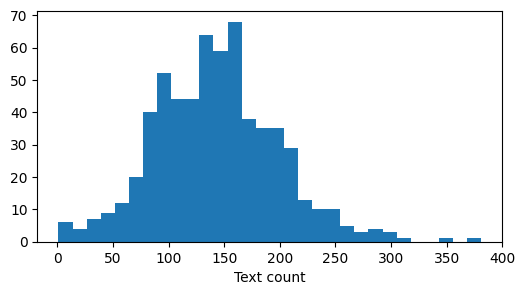

In [113]:
fig, axes = plt.subplots(1, 1, figsize=(6,3))

axes.hist(dialog_texts.groupby('movie_id').count().text, bins=30)
axes.set_xlabel('Text count')

plt.show()

### חילוץ סנטימנטים 

כעת נעבור לשימוש ב-classifier כדי לחלץ מתוך הטקסטים שקיבלנו את הסנטימנטים בכל סרט. נגדיר פונקציות עזר כדי להמיר את הסנטימנטים לfeatres ולDataFrame:

In [114]:
from tqdm.auto import tqdm

def get_emotion_feats(classifier_res):
    return {x['label']: x['score'] for x in classifier_res[0]}

def get_emotions(texts):
    for i in tqdm(range(texts.shape[0])):
        row = texts.iloc[i]
        feats = get_emotion_feats(classifier(row.text))
        feats['movie_id'] = row.movie_id
        feats['text'] = row.text
        yield feats

נחלץ את הסנטימנטים של סרט לדוגמה, נבחר למשל את הסרט "הסנדק": 

In [115]:
mid = 'm579'
emots = pd.DataFrame(get_emotions(dialog_texts[dialog_texts.movie_id == mid]))

  0%|          | 0/152 [00:00<?, ?it/s]

In [116]:
emots.head()

,surprise,joy,neutral,anger,sadness,disgust,fear,movie_id,text
0,0.651263,0.305251,0.019376,0.010028,0.007724,0.003237,0.003122,m579,Whadda ya think? Wow! Cool! Oh this looks GRE...
1,0.059026,0.176071,0.193289,0.368259,0.071702,0.061532,0.070120,m579,Well sure we can leave it up. Now go get Molly...
2,0.097328,0.485017,0.156362,0.137206,0.065327,0.021426,0.037335,m579,Oh yeah! Come on down guys. It's time for gam...
3,0.636661,0.210362,0.072752,0.031887,0.030731,0.010443,0.007164,m579,Pizza Planet?! Oh cool! Oh all this packing m...
4,0.161692,0.008879,0.785790,0.016290,0.015057,0.009662,0.002629,m579,Just one? You can bring ONE toy... Can I bring...


נוכל להציג את עוצמת הסנטימנטים שקיבלנו לאורך הסרט בצורה גרפית:

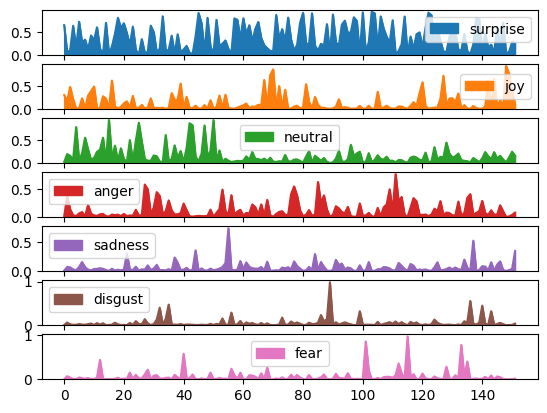

In [117]:
ax = emots.plot.area(subplots=True)
plt.show()

ניתן הסיק כמה מסקנות מהגרפים לעיל:
- קיימים סנטימנטים שנמצאים ברמה יחסית אחידה לאורך הסרט, כמו "הפתעה" במקרה הזה
- חלק מהסנטימנטים מקבלים עליות חדות מדי פעם במהלך הסרט, כמו עצבות, אבל הם אינם בהכרח מבטאים עלייה משמעותית באותו סנטימנט כיוון שמדובר במשפטים בודדים.
- אבל, יש סנטימנטים שמהם ניתן להסיק מסקנות בסבירות גבוהה יותר, כמו "אושר", שהעליות והירידות בו הן בטווחי זמן ארוכים יותר וכנרה מבטאים שינוי מהותי בסרט.

כעת נחלץ את הסנטימנטים של שאר הסרטים:

In [118]:
# movie_emots = pd.DataFrame(get_emotions(dialog_texts))
movie_emots = pd.read_pickle('./data/movie_emots')

In [119]:
movie_emots.movie_id.unique().shape

(617,)

### סיווג בעזרת מודלים

כדי לנסות לבצע סיווג ז'אנרים על פי המידע הסנטימנטלי, עלינו ראשית לצמצם את מספר הפיצ'רים. כרגע המידע שאספנו מכיל מספר לא קבוע של רשומות עבור כל סרט, ולרוב זהו מספר גדול. לכן נבצע צמצום של המידע הסנטימנטלי על ידי ביצוע ממוצע של כל סנטימנט:

In [120]:
movie_avg_emots = movie_emots.drop(['text'], axis=1).groupby('movie_id').agg(np.average)

אם נבדוק את גדלי הסנטימנטים נראה שחלק מהסנטימנטים באופן קבוע מופיעים יותר מאחרים, כמו למשל הרגש הניטרלי. לכן נבצע נרמול של ערכי הסנטימנטים. 

<AxesSubplot: >

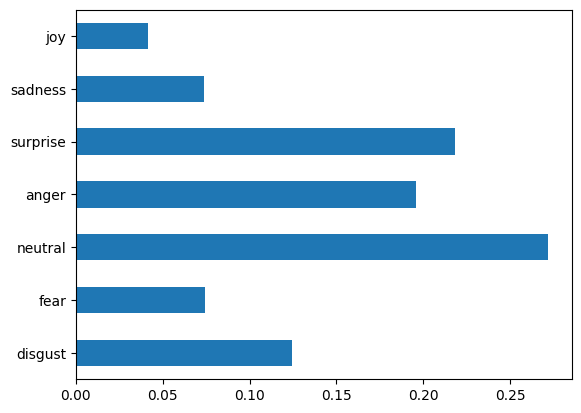

In [121]:
movie_avg_emots.head().apply(np.average).plot.barh()

In [122]:
normalized = (movie_avg_emots-movie_avg_emots.mean())/movie_avg_emots.std()

איחוד הערכים לכדי ממוצע כרוך באובדן של מידע, כיוון שאנו מתעלמים בכך ממימד הזמן, והשינויים בסנטימנטים במהלך הסרט. אך למטרתנו כרגע הממוצע מפשט בהרבה את הפיצ'רים וייתן מענה מספיק.

לפני שניגש לסיווג ננסה להמחיש את מידת ההשפעה של כל סנטימנט על הז'אנר: 

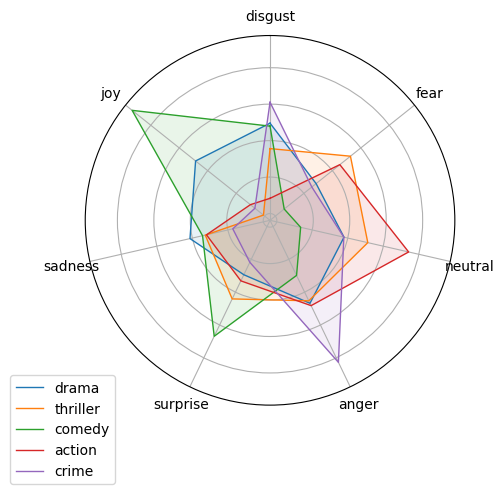

In [123]:
from math import pi

avg_emots_genres = normalized.join(meta[['genre_list']], on="movie_id", how="inner")
genre_avgs = avg_emots_genres.explode('genre_list').groupby('genre_list').agg(np.average)

def show_spider(data: pd.DataFrame, label_col: str = None):
    categories = (data.drop(label_col, axis=1) if label_col else data).columns.to_list()
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(1, 1, 1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.axes.get_yaxis().set_ticklabels([])
    for id, v in data.iterrows():
        values = (v.drop(label_col) if label_col else v).values.tolist()
        values += values[:1]
        label = str(v[label_col]) if label_col else id
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=label)
        ax.fill(angles, values, alpha=0.1)
    if len(data) > 1:
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

top_5_genres = genre_counts.nlargest(5).index
show_spider(genre_avgs.loc[top_5_genres[0:]])

בגרף לעיל מוצגים הז'אנרים הכי פופולריים מלבד "דרמה" ו"מתח" (שהם כלליים יותר כפי שהוזכר לעיל), והערך הממוצע המתאים להם עבור כל סנטימנט. ממבט ראשון ניתן לראות כי קיימים קורלציות בין ערכי הסנטימנטים לז'אנרים, ואף הם עולות בקנה אחד עם האינטואיציה.

נוכל לבצע ויזואליזציה מתקדמת על ידי שימוש בערכי הסנטימנטים בכל הסרטים, בעזר תרשים catplot שנותן מידע על הממוצע וכן על הdeviation של כלל הנתונים:

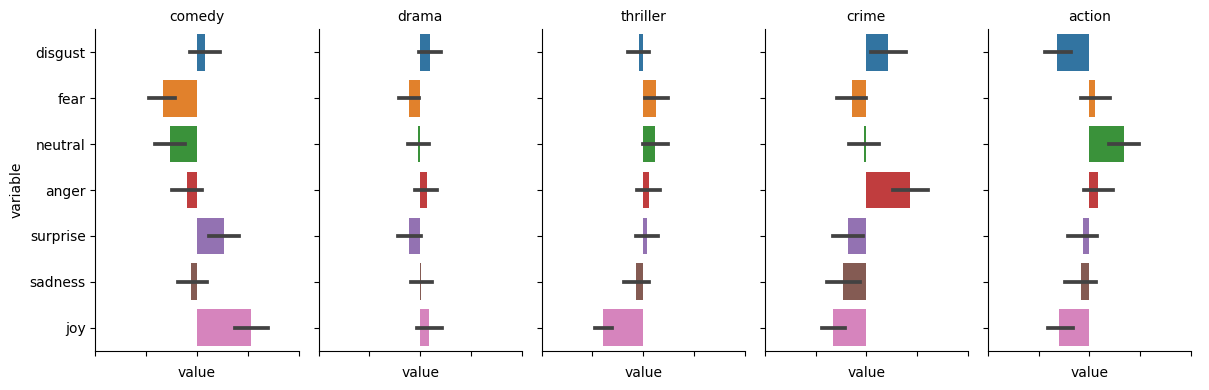

In [124]:
df = avg_emots_genres.explode('genre_list').melt(id_vars=['genre_list'])
df = df[df.genre_list.apply(lambda x : x in top_5_genres)]

g = sns.catplot(
    data=df, x="value", y="variable", col="genre_list",
    kind="bar", height=4, aspect=0.6, orient="h"
)
g.set_titles("{col_name}")
g.set_xticklabels("")
g.add_legend()
plt.tight_layout()
plt.show()

כעת ננסה להשתמש בממוצעי הסנטימנטים עבור אימון מודלים של למידה מפוקחת בסיסיים, כאלו הקיימים ב-sklearn. משימת התיוג היא מרובת תגיות כיוון שלכל סרט יכולים להיות כמה ז'אנרים, לכן היא מורכבת יותר ממשימת סיווג רגילה. על פי [הדוקומנטציה הרשמית של sklearn](https://scikit-learn.org/stable/modules/multiclass.html), כמה מהמודלים הקיימים של למידה מפוקחת כמו RandomForestTree מתאימים באופן מובנה לסיווג של מספר תגיות, לכן נוכל להשתמש בהם כרגיל.

בגלל כמות הז'אנרים המשתנה שהוזכרה למעלה, נמצא את 5 הז'אנרים הכי פופולריים, וסנן את הז'אנרים של הסרטים על פי רשימה זו. כמו כן נסנן את הסרטםי שכמות הדיאלוגים בהם קטנה מ-50, כיוון שכפי שהוזכר המידע בהם חסר או לא רלוונטי. לאחר מכן נחלק את הנתונים לקבוצת אימון וקבוצת בדיקה בעזרת train_test_split של sklearn. נבחר לקחת 20% מהנתונים להיות בקבוצת הבדיקה.

אנו משאירים בתוך ה-dataset שלנו גם סרטים שלא מכילים את הז'אנרים הפופולריים שבחרנו, כיוון שגם רשימה ריקה של תגיות יכולה לעזור בתהליך הסיווג.

In [125]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

top_genres = genre_counts.nlargest(5).index
print('top genres:', top_genres.to_list())

def get_genre_sets(X, labels, genres):
    filtered_genres = [[g for g in x if g in genres] for x in labels]
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(filtered_genres)
    return train_test_split(X, y, test_size=0.2, random_state=1) + [mlb]

mids_valid = movie_emots.movie_id.value_counts() >= 50
X = normalized.loc[mids_valid].iloc[:, 0:7]
y = meta.loc[X.index].genre_list
X_train, X_test, y_train, y_test, mlb = get_genre_sets(X, y, top_genres)

top genres: ['drama', 'thriller', 'comedy', 'action', 'crime']


כדי להשתמש במסווג עם כמה תגיות לכל רשומה, השתמשנו לעיל ב-[MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) כדי להמיר כל רשימת ז'אנרים למערך בינארי, כך שכל אינדקס במערך מתאים לז'אנר אחר. לדוגמה:

In [126]:
mlb.transform([['action', 'comedy']])

array([[1, 1, 0, 0, 0]])

כעת נאמן מודל קלאסי של RandomForest על סט האימון:

In [127]:
from sklearn.ensemble import RandomForestClassifier 
rf_clf = RandomForestClassifier(n_estimators=100, random_state=1)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

ננסה למדוד את מידת הדיוק של המודל על סט הבדיקה בעזרת score:

In [128]:
rf_clf.score(X_test, y_test)

0.18487394957983194

קיבלנו מספר נמוך מאוד, אך זאת מכיוון שאנו משתמשים בסיווג MultiLabel. החישוב הרגיל של score מחלק את מספר הסיווגים הנכונים במספר הרשומות, וכאן בסיווג רב-תגי סיווגים נכונים הם סיווגים שהתאימו את הז'אנרים באופן מדויק. לכן כל סיווג שהוא נכון באופן חלקי, יחשב אוטומטית כלא נכון, ויוריד מהציון.

כדי לתת מענה לבדיקת רמת הדיוק של המודל, עלינו להפריד בין הסוגים השונים של סיווג לא נכון - 
1. False Positive (FP) = תיוג סרט כבעל ז'אנר מסוים בניגוד למידע הנתון
2. False Negative (FN) = אי-תיוג סרט עם ז'אנר שנמצא במידע הנתון

קיימים [מדדים אחרים](https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics) לבדיקת מידת הדיוק של מסווגים, שמתייחסים לסוגי השגיאות לעיל: 
- מדד precision, מחשב את את הדיוק של כל סיווג רשומה בנפרד ע"י חילוק מספר התגיות שתויגו נכון חלקי מספר התגיות שתויגו בסה"כ, ואז מחשב את הממוצע. מדד זה נותן ציון עבור הסיווגים החיוביים (Positive) 
- מדד recall מבצע חישוב דומה, אך מדד הדיוק של כל רשומה נמדד ע"י חילוק מספר התגיות שתויגו נכון חלקי מספר התגיות האמיתי. מדד זה נותן ציון עבור אי-הסיווגים (Negative) 
- מדד f1 שהוא שילוב של 2 המדדים recall ו-precision 

עבור כל מדד שהוזכר, הממוצע של כל מדד יכול להתבצע בכמה דרכים, macro, micro, weighted, ו-samples. לא ניכנס לפרטים איך כל אחד מחושב, למטרתנו יספיק להתמקד באחד מהם. את הנתונים שהזכרנו ניתן להציג בעזרת הפונקציה classification_report: 

In [129]:
from sklearn.metrics import classification_report

def report_clf(clf, X, y, classes):
    y_predict = clf.predict(X)
    return classification_report(
        y,
        y_predict,
        target_names=classes,
        zero_division=1
    )

print(report_clf(rf_clf, X_test, y_test, mlb.classes_))

              precision    recall  f1-score   support

      action       0.33      0.15      0.21        26
      comedy       0.70      0.17      0.28        40
       crime       0.20      0.03      0.06        31
       drama       0.47      0.53      0.50        60
    thriller       0.56      0.59      0.57        49

   micro avg       0.50      0.35      0.41       206
   macro avg       0.45      0.30      0.32       206
weighted avg       0.48      0.35      0.37       206
 samples avg       0.58      0.41      0.39       206



קיבלנו מידע מפורט יותר וציונים יותר מדוייקים. בפרט נראה שערכי הpercision גבוהים יותר מה-recall, כלומר שגיאות FN (תיוג חסר) נפוצות יותר משגיאות FP (תיוג עודף). 

נראה שיש הבדל משמעותי בין הז'אנרים. כדי להמחיש את התמונה טוב יותר נציג את ה-confusion matrix המתאים לכל ז'אנר: 

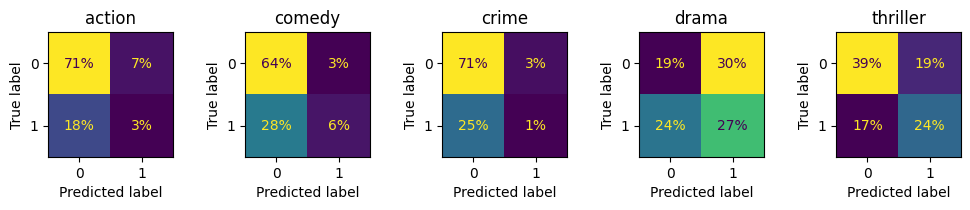

In [130]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

def show_conf_matrices(X_test, y_test, clf, classes, axs):
    y_predict = clf.predict(X_test)
    i = 0
    for cm in multilabel_confusion_matrix(y_true=y_test, y_pred=y_predict):
        genre = classes[i]
        axs[i].set_title(genre)
        s = cm.sum()
        cm_percent = np.array([[x / s for x in r] for r in cm])
        ConfusionMatrixDisplay(cm_percent).plot(ax=axs[i], colorbar=False, values_format=".0%")
        i += 1

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
show_conf_matrices(X_test, y_test, rf_clf, mlb.classes_, axs)
plt.tight_layout()


נראה שבז'אנרים "דרמה" ו"מתח" שגיאת ה-FP גבוהה יותר משאר הז'אנרים. כפי שהזכרנו לעיל אלו 2 הז'אנרים הכלליים והנפוצים יותר שנמצאים במאגר, ולכן הגיוני כי המודל שלנו סיווג הרבה מהסרטים כדרמה ומתח למרות שבפועל הם לא מתויגים כך.

מצד שני, שלושת הז'אנרים האחרים הם בעלי שגיאת FP כמעט אפסית, אך שגיאת ה-FN עדיין גדולה. הסבר אפשרי לגבי הז'אנר "פעולה" למשל, הוא שייתכן וגם הוא יחסית כללי ולכן השגיאה בו יחסית גבוהה, אך גם בז'אנר "פשע" יש שגיאת FN גבוהה. הסבר אחר יכול להיות מספר נתונים לאימון קטן, שכן על פי המטריצות שלושת הז'אנרים הללו נמצאים רק  ב20 - 30% מסך סט האימון. כמו כן ייתכן כי קיימים פערים בתיוג הז'אנרים, כלומר יש סרטים שלהם ז'אנר מרכזי שאינו נכלל ב-5 הז'אנרים הפופולריים, והוא הז'אנר שהכי מייצג את הסרט והוא לא נכלל בתהליך הסיווג. הסבר נוסף יכול להיות פשוט חוסר תאימות בנתונים.

ניתן לבדוק את ההשפעה של דרמה ומתח על ידי אימון מודל חדש בלעדיהם:

genres: ['comedy', 'action', 'crime']


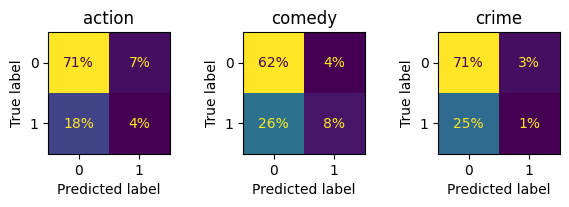

In [131]:
next_genres = genre_counts.nlargest(5).index[2:]
print('genres:', next_genres.to_list())
X_train_1, X_test_1, y_train_1, y_test_1, mlb_1 = get_genre_sets(X, y, next_genres)
rf_clf_1 = RandomForestClassifier(n_estimators=100, random_state=1)
rf_clf_1.fit(X_train_1,y_train_1)
fig, axs = plt.subplots(1, 3, figsize=(6, 2))
show_conf_matrices(X_test_1, y_test_1, rf_clf_1, mlb_1.classes_, axs)
plt.tight_layout()

נראה כי ערכי הrecall של שלושת הז'אנרים לא השתנו באופן מהותי. לכן לדרמה ומתח לא היתה השפעה משמעותית על השגיאות בסיווג שאר הז'אנרים, וככל הנראה הן נובעות מההסברים שהבאנו לעיל, כלומר בעיות שנובעות מהנתונים עצמם.

ננסה לאמן מודל אחר מ-RandomForest, למשל מודל המשתמש באלגוריתם Naive Bayes. המודל GaussianNB של sklearn אינו תומך באופן מובנה בסיווג Multi-Label, אבל נוכל להשתמש בו על ידי עטיפתו ב-OneVsRestClassifier, אשר מאפשר תיוג כזה על ידי אימון של המודל כמודל בינארי בנפרד על כל ז'אנר, ואז מבצע predict בעזרת Binary Relevance, כלומר איחוד התוצאות של סיווג כל ז'אנר לרשימה. 

              precision    recall  f1-score   support

      action       0.38      0.31      0.34        26
      comedy       0.59      0.33      0.42        40
       crime       0.53      0.29      0.38        31
       drama       0.46      0.43      0.44        60
    thriller       0.56      0.69      0.62        49

   micro avg       0.51      0.44      0.47       206
   macro avg       0.50      0.41      0.44       206
weighted avg       0.51      0.44      0.46       206
 samples avg       0.56      0.49      0.42       206



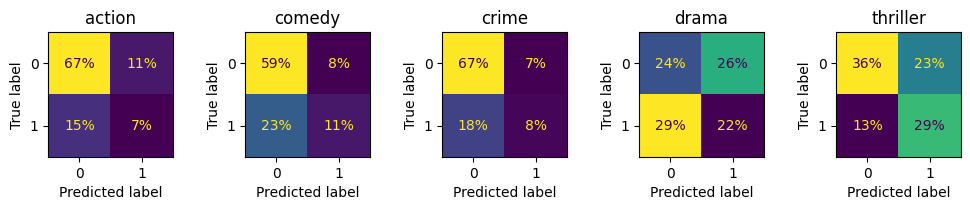

In [132]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB

nb_clf = OneVsRestClassifier(GaussianNB())
nb_clf.fit(X_train, y_train)
print(report_clf(nb_clf, X_test, y_test, mlb.classes_))
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
show_conf_matrices(X_test, y_test, nb_clf, mlb.classes_, axs)
plt.tight_layout()

אנו רואים כי בחלק מהז'אנרים שגיאת ה-FN ירדה כמו קומדיה ופשע, אך במקביל שגיאת FP עלתה. לכן נראה כי שימוש במודל גאוסייני במקום יער החלטה לא עזר בשיפור הדיוק של המודל, אך שיפר את ציון הrecall בחלק מהז'אנרים, והציון הכללי של המודל עלה.

### שימוש בexplainer להבנת המודל

נבדוק מה המודל שאימנו למד, כלומר עד כמה כל סנטימנט השפיע על התוצאה של הסיווג. נבדוק ראשית את חשיבות כל feature מתוך המודל:

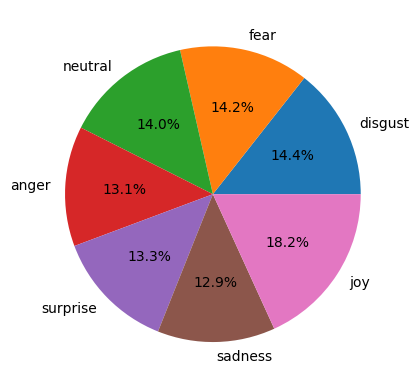

In [133]:
importances = rf_clf.feature_importances_
sentiments = list(movie_emots.columns[0:7])
plt.pie(importances, labels=sentiments,autopct='%1.1f%%')
plt.show()

נראה שלסנטימנט שמחה יש השפעה קצת יותר גדולה על ההחלטה משאר הסנטימנטים, אך באופן כללי נראה כי כולם מקבלים משקל דומה.

נשתמש בספריה [SHAP](https://github.com/slundberg/shap) כדי להבין יותר טוב את תהליך ההחלטה של המודל שאימנו:

In [134]:
import shap

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer(X_test)
shap_values.shape

(119, 7, 10)

התוצאה של shap_values מכילה מידע על גודל ההשפעה של כל פיצ'ר, על כל תיוג (class), עבור כל רשומה בtest set. במקרה הזה מספר התיוגים/classes מבחינת SHAP הוא 10, מכיוון שקיימים 5 ז'אנרים אפשריים, ועבור כל ז'אנר קיימות שתי אפשרויות - מתויג ולא מתויג. מבחינה עקרונית במקרה הזה כל ערך של תיוג ז'אנר יהיה המשלים של אי-תיוג ז'אנר, לכן לא יהיה טעם להשוות ביניהם.

נבחר להסתכל על תהליך הסיווג של רשומה אקראית מתוך סט הבדיקה: 

In [135]:
np.random.seed(0)
sample_i = np.random.randint(0, len(X_test))
chosen_instance = X_test.iloc[sample_i]
print('actual:', meta.loc[chosen_instance.name].genre_list)
print('used:', mlb.inverse_transform(y_test[sample_i:sample_i+1]))
print('predicted:', mlb.inverse_transform(rf_clf.predict(X_test.iloc[sample_i:sample_i+1])))

actual: ['crime', 'action', 'sci-fi']
used: [('action', 'crime')]
predicted: [('drama',)]


ניתן לראות כי הז'אנר מד"ב לא נלקח בחשבון בסיווג. נתבונן ספציפית בז'אנר דרמה, שבו הרשומה תויגה:

In [136]:
shap_values_i = explainer.shap_values(chosen_instance)
shap.initjs()
genre_i = np.where(mlb.classes_ == 'drama')[0][0] * 2 + 1
shap.force_plot(explainer.expected_value[genre_i], shap_values_i[genre_i], chosen_instance, feature_names=sentiments)

אנו רואים כי כמה מהסנטימנטים גרמו לסרט להיות מתויג כ"דרמה": ערך שמחה ממוצע, ערך ניטרליות נמוך, וערך עצב גבוה. ערך השמחה נראה כמשפיע הגדול ביותר על ההחלטה, מה שיכול להיות הגיוני במקרה של דרמה, אך ייתכן ויש כאן עדיפות יתר. 

נוכל לבחון גם ז'אנרים נוספים כמו פעולה, שבמקרה הזה לא תויגה, אך בפועל הסרט הוא כן פעולה:

In [137]:
genre_i = np.where(mlb.classes_ == 'action')[0][0] * 2 + 1
shap.force_plot(explainer.expected_value[genre_i], shap_values_i[genre_i], chosen_instance, feature_names=sentiments)

אנו רואים שבמקרה הזה רמת השמחה תרמה רבות לכך שהסרט לא תויג כפעולה, מה שכנראה מצביע על חשיבות יתר שניתנה לשמחה כאן. למרות הכל הז'אנרים שבדקנו (דרמה ופעולה) הם ז'אנרים כלליים, ולכן הגיוני כי הסנטימנטים הממוצעים הם אלו שגרמו לחוסר התאימות בסיווג.

## clustering בעזרת חילוץ פיצ'רים

### חילוץ פיצ'רים בעזרת pipeline 

גישה אחרת לסיווג הסרטים לפי הטקסטים שלהם היא בעזרת חילוץ פיצ'רים מתוך הטקסט שאינם הרמות הסנטימנטליות באופן ישיר. למשל, ניתן להשתמש במודל שהורדנו מ-🤗 עם task אחר שנקרא feature-extractor כדי ליצור pipeline שמבצע tokenization ואז חילוץ פיצ'רים כפי שנעשה במסווג למעלה, אך אינו מפעיל אליהם את המודל DL עצמו:

In [138]:
extractor = pipeline("feature-extraction",
                      model="j-hartmann/emotion-english-distilroberta-base", top_k=None)

Some weights of the model checkpoint at j-hartmann/emotion-english-distilroberta-base were not used when initializing RobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for p

In [139]:
np.array(extractor("Hi how are you?")).shape

(1, 7, 768)

הfeature extractor מחזיר רשימה של inputים עבור כל token שאחר כך מוזנת למודל עצמו. אנו רואים בדוגמה לעיל שכמות הtokens במשפט היא 7, וכמות הinputs שהמודל מקבל היא 768. 

נוכל לחלץ את הinputים מתוך הטקסטים של הסרטים ולהתייחס אליהם כfeatures נפרדים של הטקסט. כיוון שהinputים הם נפרדים לכל token בטקסט, נאלץ לבצע איחוד שלהם כדי להתייחס אליהם כfeatures של כל הטקסט, למשל הגיוני לעשות זאת בעזרת ממוצע: 

In [140]:
def get_text_features(text):
    features = extractor(text)
    return np.mean(features[0], axis=0)

get_text_features("Hi how are you?").shape

(768,)

כעת נבצע חילוץ של הפיצ'רים עבור רשימת הדיאלוגים, כפי שעשינו עם חילוץ הסנטימנטים לעיל. נעשה זאת על רשימה חלקית של הסרטים (300) כיוון שמדובר בכמות גדולה של עמודות ולמטרתנו אין צורך ביותר מדי רשומות. 

In [856]:
def get_emot_feats(df):
    for i in tqdm(range(len(df))):
        dt = dialog_texts.iloc[i]
        feats = get_text_features(dt.text)
        fdict = {'f%d' % i:feats[i] for i in range(len(feats))}
        fdict['movie_id'] = dt.movie_id
        yield fdict

movie_emot_feats = pd.DataFrame(get_emot_feats(dialog_texts.iloc[:45075]))

In [141]:
movie_emot_feats = pd.read_pickle('./data/movie_emot_feats')
movie_emot_feats.movie_id.unique().shape

(300,)

כעת יש לנו רשימה של 768 פיצ'רים עבור כל טקסט בכל סרט. כרגע לכל סרט יש סט של פיצ'רים ככמות הדיאלוגים בו, לכן כדי לצמצם את כמות הפיצ'רים לסרט לבצע ממוצע כפי שעשינו לעיל עם רמות הסנטימנטים. כמו כן נתעלם מסרטים בעלי מספר קטן של דיאלוגים, כיוון שהמידע שלהם לא מספיק ולא יהיה מייצג לז'אנרים שלהם. 

In [142]:
vc = movie_emot_feats.movie_id.value_counts()
mid_filter = vc[vc >= 50].index
movie_avg_feats = movie_emot_feats.groupby('movie_id').agg(np.mean).loc[mid_filter]
movie_avg_feats.shape

(291, 768)

### הורדת מימד

כרגע כמות הפיצ'רים שקיבלנו היא ענקית, ולא מאפשרת לנו לבצע הפרדה פשוטה בין הסוגים השונים של הסרטים ולא לבצע ויזואליזציה של ערכי הפיצ'רים. כדי להתמודד עם הכמות הגדולה, ננסה לצמצם את כמות הפיצ'רים על ידי הורדת מימד באמצעות PCA (Principal Component Analysis).

ראשית נבצע נורמליזציה של הנתונים:

In [143]:
movie_avg_feats_norm = (movie_avg_feats - movie_avg_feats.mean()) / movie_avg_feats.std()

מספר הפיצ'רים האופטימלי אינו ידוע, לכן ננסה קודם לצמצם ל-2 פיצ'רים:

In [144]:
from sklearn.decomposition import PCA 

def do_pca(df, n_components):
    pca = PCA(n_components=n_components) 
    principal_components = pca.fit_transform(df) 
    cols = ['pc%d' % i for i in range(n_components)]
    return pd.DataFrame(data=principal_components, columns=cols, index=df.index)

bin_principal_df = do_pca(movie_avg_feats_norm, 2)
bin_principal_df

,pc0,pc1
m289,20.324286,15.943726
m90,5.315935,7.767675
m238,-17.242699,-1.003536
m100,14.204277,-1.907875
m105,12.850226,-1.382197
...,...,...
m81,-7.038883,7.873992
m226,-23.823837,4.455986
m96,-21.185912,-5.686180
m56,-2.486457,-13.024573


ננסה לבדוק האם שני הפיצ'רים שקיבלנו מבטאים הבדלים בין הסיווגים של הסרטים, כלומר הז'אנרים, באמצעות ויזואליזציה: 

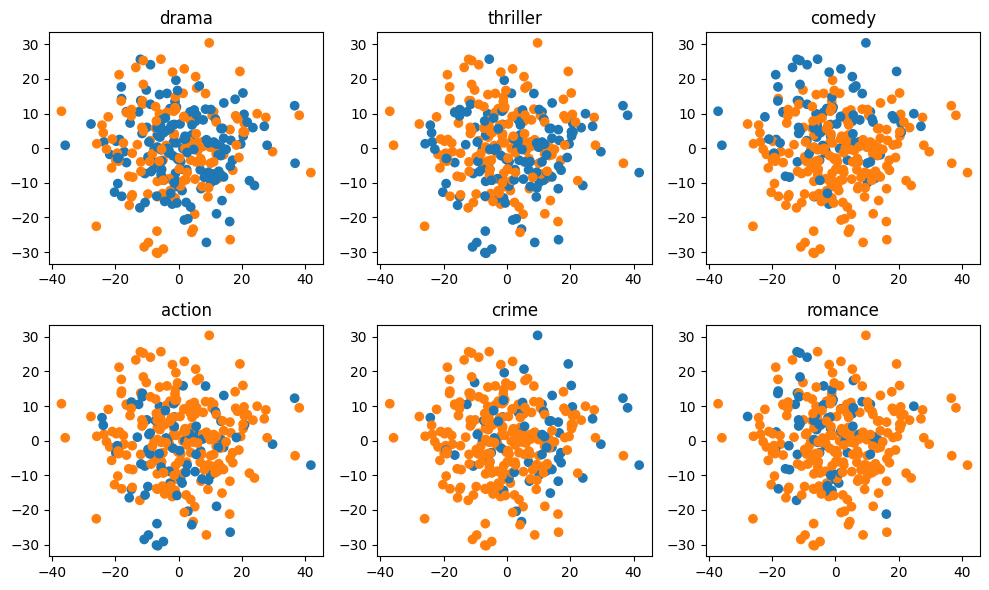

In [145]:
gs = meta.loc[bin_principal_df.index].genre_list

plt.figure(figsize=(10, 6))
for i, g in enumerate(genre_counts.nlargest(6).index):
    ax = plt.subplot(2, 3, i +1)
    is_genre = [0 if g in gs.loc[mid] else 0.1 for mid in bin_principal_df.index]
    ax.set_title(g)
    ax.scatter(bin_principal_df.pc0, bin_principal_df.pc1, c=is_genre, cmap='tab10', vmax=1)

plt.tight_layout()
plt.show()

הנקודות הכחולות הן סרטים שנמצאים בז'אנר, וכתומות סרטים שלא.

ניתן לראות כי מצד אחד עבור חלק מהז'אנרים כמו קומדיה ופשע, המידע ממימד 2 נותן מידע כלשהו על השיוך לז'אנר, כיוון שסרטי קומדיה נראים כמשוייכים לחלק החיובי של pc1, וסרטי פשע משויכים לחלק החיובי של pc0, אך מצד שני כל אחד מהז'אנרים אינו ניתן להפרדה לינארית, ואף לא-לינארית במרחב הדו-ממדי, והסרטים מעורבבים אחד עם השני.

לפיכך ניתן להסיק כי צמצום המרחב ל2 ממדים שמר על מידע כלשהו, אך הוא אינו מספיק כדי לתת מענה לסיווג ז'אנרים. ננסה כעת לבצע הורדת ממד ל-6 ממדים, שהוא מספר דומה לכמות הסנטימנטים שבהם השתמשנו לסיווג ז'אנרים:

In [146]:
hex_principal_df = do_pca(movie_avg_feats_norm, 6)
hex_principal_df.shape

(291, 6)

נבדוק את מידת ההשפעה של כל פיצ'ר על הז'אנר בעזרת חישוב ממוצע עבור כל ז'אנר כפי שעשינו עבור הסנטימנטים: 

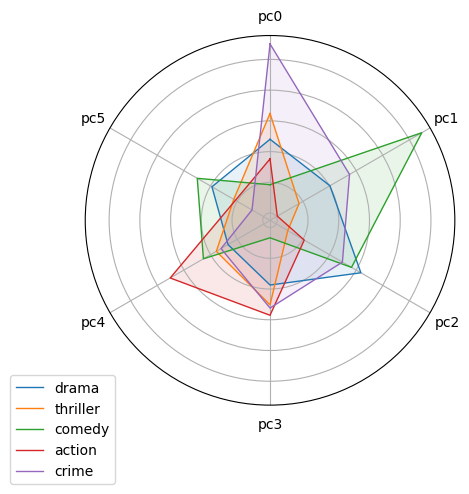

In [147]:
avg_pca_genres = hex_principal_df.join(meta[['genre_list']], how="inner")
genre_avg_pcas = avg_pca_genres.explode('genre_list').groupby('genre_list').agg(np.mean).loc[top_5_genres]

show_spider(genre_avg_pcas)

קיבלנו תרשים הדומה מאוד לתרשים שהתקבל עבור הסנטימנטים:
- הז'אנרים דרמה ומתח אינם מתבלטים בפיצ'ר מסוים, מה שמסתדר עם העובדה שהם ז'אנרים כלליים יותר
- הז'אנרים קומדיה ופשע מתבלטים כל אחד בערך גבוה של פיצ'ר מסוים, ואם נבצע הקבלה לסנטימנטים, נוכל להסיק כי הפיצ'ר pc0 הוא בעל קורלציה לסנטימנט "כעס", ו-pc1 בעל קורלציה לסנטימנט "שמחה"

ניתן להסיק כי הורדת המימד ל-6 נותנת מידע השקול למידע הסנטימנטלי מבחינת התרומה לסיווג ז'אנרים 

### clustering

מלבד הורדת מימד, ניתן להשתמש בפיצ'רים שחילצנו כדי לבצע אלגוריתם למידה בלתי מפוקחת או clustering כדי למצוע תבניות ומכנים משותפים בין הסרטים. נשתמש באלגוריתם K-Means.

כדי להפעיל את האלגוריתם יש לבחור ראשית את מספר המקבצים שאנו רוצים למצוא. במקרה הזה מספר המקבצים הרצוי אינו ידוע, לכן בחירת המספר היא בעיה בפני עצמה. למרות זאת, אנו יכולים לתת הערכה למספר מקבצים שיחשב סביר עבור הבעיה שלנו, כיוון שעבור מטרתנו סיווג הסרטים צריך להיות בסדר גודל של מספר הז'אנרים האפשריים, כיוון שמספר קטן יותר ייתן סיווג כללי מדי, ומספר גדול יותר ייתן סיווג פרטני מדי. כלומר מספר הקלאסטרים צריך להיות בין 5 ל-15 בערך. לנוחיותנו נבחר את המספר 6 כיוון שהוא מספיק וקל לויזואליזציה.

In [148]:
from sklearn.cluster import KMeans 

n_clusters=6
kmeans = KMeans(n_clusters=n_clusters, random_state=0) 
kmeans.fit(movie_avg_feats)
pred_clusters = kmeans.predict(movie_avg_feats) 

ננתח את הקלאסטרים שקיבלנו בעזרת ויזואליזציה. נעשה זאת על ידי בחינה של התפלגות הז'אנרים בכל קלאסטר, כלומר כמה אחוז תופס כל ז'אנר מסך כל הסרטים, והשוואה להתפלגות הז'אנרים הבסיסית של כלל הסרטים במאגר: 

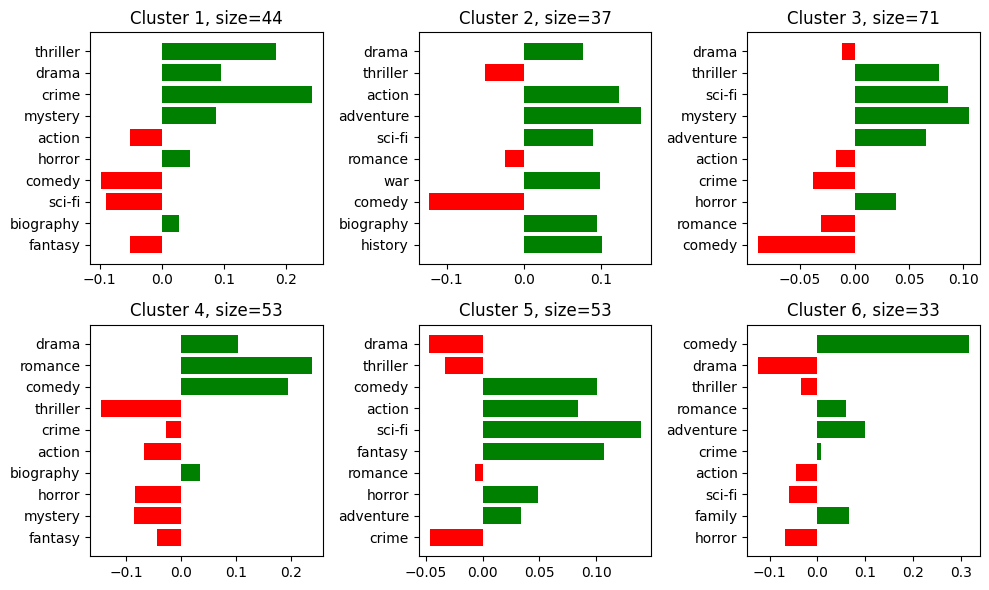

In [149]:
plt.figure(figsize=(10, 6))

def show_cluster_genre_diff(mids, ax, i, n=10):
    gc = meta.loc[mids].genre_list.explode().value_counts()
    x = gc.index[:n]
    p = np.array([gc.loc[g] / len(mids) for g in x])
    orig_p = np.array([genre_counts.loc[g] / len(meta) for g in x])
    y = p - orig_p
    clrs = ['red' if (y1 < 0) else 'green' for y1 in y ]
    ax.set_title('Cluster {}, size={}'.format(i + 1,len(mids)))
    ax.barh(x, y, color=clrs)
    ax.invert_yaxis()
                 
for i in range(n_clusters):
    ax = plt.subplot(2, 3, i+1)
    mids = [movie_avg_feats.index[j] for j in range(len(movie_avg_feats)) if pred_clusters[j] == i]
    show_cluster_genre_diff(mids, ax, i)

plt.tight_layout()
plt.show()

מתוך הגרפים ניתן למצוא מאפיינים משותפים לכל קלאסטר:
1. מתאפיין בסרטים השייכים לקטגוריה של מתח ומסתורין
2. מכיל מגוון רחב של סרטים אך נראה שהוא מתאפיין בסרטים ניטרליים יותר
3. גם הוא מתאפיין במתח ומסתורין, אך בולט יותר בסרטי הרפתקה מאשר דרמה
4. מכיל סרטי קומדיה ורומנטיקה, או רומ-קום
5. מכיל סרטי מד"ב ופנטזיה, אך גם קומדיה ואימה... ייתכן והמאפיין המשותף הוא הסנטימנט "הפתעה"
6. מתאפיין בעיקר בקומדיה, הרפתקה ומשפחה

## ניתוח בעזרת Time Series

בכל הניתוחים שביצענו עד כה, כאשר ביצענו חילוץ פיצ'רים היינו צריכים להתמודד עם כמות גדולה של מידע כיוון שבכל סרט ישנם הרבה דיאלוגים ובכמות משתנה. כדי לקבל מספר קטן של פיצ'רים, ניתחנו את הדיאלוגים בסרט ואיחדנו את תוצאות, למשל בעזרת ממוצע. בכך קיבלנו dataset פשוט יותר, אך איבדנו מידע על השינויים בנתונים לאורך זמן הסרט.

דרך אחרת להתייחס למידע שחולץ מהדיאלוגים הוא באמצעות [Time Series](https://en.wikipedia.org/wiki/Time_series), כלומר סדרה של מדידות לאורך זמן. על ידי המרת הנתונים לTS ניתן להשתמש בשיטות הרבות לניתוח הקיימות עבורן, כגון זיהוי מגמות, ניבוי ועוד. נשתמש בספריה [tslearn](https://tslearn.readthedocs.io/en/stable/index.html) שמספקת כלים לניתוח TS המבוססת על sklearn.

יש אמנם הבדל משמעותי בין Time Series רגיל למידע שברשותנו, מכיוון ש-TS מורכב מסדרה של מדידות בזמנים קבועים, וברשימת הדיאלוגים אין מידע על זמנים, ואין הבטחה שכל דיאלוג נמצא ברווחי זמן קבועים. למרות זאת, ננסה לנתח את המידע כ-TS רגיל כיוון שהוא מייצג סדרה של אירועים ולכן עדיין ניתן להתייחס אליו כסוג של TS. 

### עיבוד מקדים

נרצה להפוך את המידע הסנטימנטלי שחילצנו למעלה לרשימה של Time Series, עם פיצ'רים המתאימים לסנטימנטים. tslearn מצפה לפורמט של TS בצורה של מערך מספרי דו-ממדי, כאשר כול איבר במערך מייצג מדידה אחרת, וכל מדידה מורכבת ממספר פיצ'רים. כאשר מטפלים ב-dataset של TS, המידע הוא מערך תלת מימדי, המכיל רשימה של TS.

נמיר את המידע לפורמט הרצוי. נשתמש ב-to_time_series_dataset של tslearn:

In [150]:
from tslearn.utils import to_time_series_dataset

ts_movie_ids = np.array([])

def get_movie_ts(movie_emots: pd.DataFrame):
    for i, row in movie_emots.iterrows():
        yield row[0:7].to_list()

def get_time_series():
    global ts_movie_ids
    emots_grouped = movie_emots.groupby('movie_id')
    with tqdm(total=len(emots_grouped)) as pbar:
        for mid, group in emots_grouped:
            ts_movie_ids = np.append(ts_movie_ids, mid)
            lst = list(get_movie_ts(group))
            yield lst
            pbar.update(1)

movie_emots_ts = to_time_series_dataset(list(get_time_series()))

  0%|          | 0/617 [00:00<?, ?it/s]

In [151]:
movie_emots_ts.shape

(617, 381, 7)

גודל כל TimeSeries הוא 381, כיוון שזוהי הכמות המקסימלית של דיאלוגים בסרט. בשאר הסרטים הערכים במיקומים הגבוהים הם nan. כדי לשפר את הdataset שקיבלנו נסנן את הסרטים שמכילים מספר קטן של דיאלוגים כיוון שהם בעלי מידע מועט מדי ולא יתרמו לתוצאה. 

בנוסף נשתמש ב-scaler אשר ינרמל את ערכי הסנטימנטים, כיוון שברצוננו לבצע השוואה ללא התייחסות לגודלי הערכים האמיתיים. 

In [152]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import ts_size

min_dialogs = 50
ts_train_set_idx = np.array([i for i in range(len(movie_emots_ts)) if ts_size(movie_emots_ts[i]) >= min_dialogs])
np.random.seed(0)
np.random.shuffle(ts_train_set_idx)
ts_train_set = movie_emots_ts[ts_train_set_idx]
ts_train_set_ids = ts_movie_ids[ts_train_set_idx]
ts_train_set = TimeSeriesScalerMeanVariance().fit_transform(ts_train_set)

במקרה שלנו אנו רוצים לבצע השוואות בין סרטים על פי המגמות בסנטימנטים שלהם במהלכם, לכן כאן אין משמעות מיוחדת למספר הדיאלוגים בסרט, אלא לקו הכללי. לכן יהי נחמד ויותר יעיל אם נוכל לצמצם את כל המידע בכל סרט לכמות קבועה של דגימות. ניתן לעשות זאת באמצעות resampler, אשר מקבל גודל חדש רצוי ומתאים את הסדרה אליו על ידי דגימה מחדש של הנתונים במרווחים.

In [153]:
from tslearn.preprocessing import TimeSeriesResampler

new_sample_size = 30
ts_train_set_rs = TimeSeriesResampler(sz=new_sample_size).fit_transform(ts_train_set)
ts_train_set_rs.shape

(591, 30, 7)

הבעיה ב-resample הברירת מחדל של tslearn היא שבדגימה החדשה מתעלמים מהנתונים שנמצאים במרווחים בין הדגימות, ואף tslearn [מזהירים](https://tslearn.readthedocs.io/en/stable/variablelength.html#resampling) על כך בדוקומנטציה שלהם. למשל עבור הנתונים הבאים, כמעט כל הפיקים בחצי השני של הסרט נעלמו לאחר הresample:

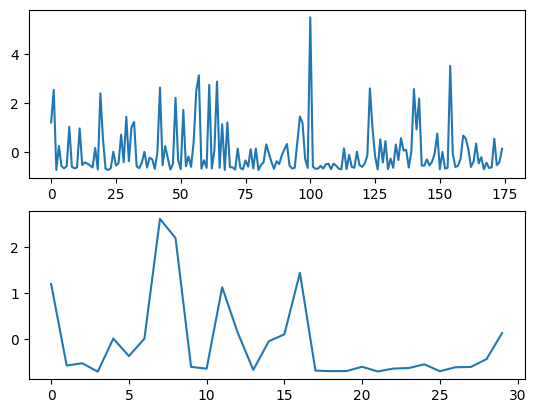

In [154]:
plt.subplot(211)
plt.plot(ts_train_set[0][:, 0])
plt.subplot(212)
plt.plot(ts_train_set_rs[0][:, 0])

דרך אחרת לבציע resample היא באמצעות אופרטורים אחרים הפועלים על המרווחים, כמו ממוצע. בדרך כלל ב-TS משתמשים בresampling על פי מרווחי זמן (למשל ב-resample של [pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling)), אך כיוון שבמקרה שלנו נוכל להשתמש בחלוקה פשוטה לתת-מערכים, נממש את המתודה בעצמנו: 

In [155]:
def resample(X, size, operator):
    n_ts, sz, d = X.shape
    X_out = np.empty((n_ts, size, d))
    for i in range(X.shape[0]):
        sz = ts_size(X[i])
        for di in range(d):
            split = np.array_split(X[i, :sz, di], size)
            X_out[i, :, di] = np.fromiter(map(operator, split), dtype=split[0].dtype)
    return X_out

ts_train_set_rs_1 = resample(ts_train_set, new_sample_size, np.mean)
ts_train_set_rs_1 = TimeSeriesScalerMeanVariance().fit_transform(ts_train_set_rs_1)
ts_train_set_rs_1.shape

(591, 30, 7)

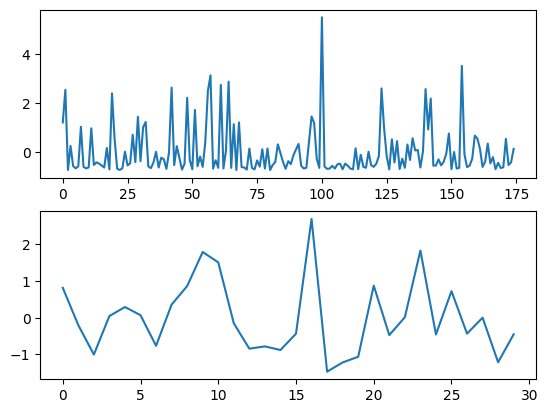

In [156]:
plt.subplot(211)
plt.plot(ts_train_set[0][:, 0])
plt.subplot(212)
plt.plot(ts_train_set_rs_1[0][:, 0])

וקיבלנו תוצאה טובה יותר הקרובה יותר למקור.

### K-Means Clustering

לאחר שביצענו preprocessing, אחד הדרכים שאנו יכולים לנתח את המידע היא בעזרת למידה בלתי מפוקחת וקלאסטרינג, גלומר שימוש בסדרות ערכי הסנטימנטים כדי לאתר תבניות משותפות בין סרטים ולקבץ אותם לקבוצות בעלי מכנים משותפים. 

ניתן לעשות זאת בעזרת אלגוריתם K-Means, שנמצא בספריה tslearn. האלגוריתם הבסיסי של K-Means משתמש במרחקים בין הנקודות (שמימדיהם הם הפיצ'רים) כדי למצוא מרכזים משותפים עבור כל מקבץ, כאשר במקרה של TS המרכז גם הוא TS. גם במקרה הזה כפי שהזכרנו לעיל, בחירת מספר הקלאסטרים היא אינה טריוויאלית אך סדר הגודל ידוע, לכן נבחר בהתחלה שרירותית את המספר 8. 

In [157]:
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 8
km = TimeSeriesKMeans(n_clusters=n_clusters, n_init=3, random_state=0)
y_pred = km.fit_predict(ts_train_set_rs_1)

הפרמטר n_init אומר את מספר האיטרציות שהאלגוריתם מבצע כאשר בכל איטרציה בוחרים את הseeds באופן אקראי. התוצאה של fit_predict מחזירה מערך של מספרים, כאשר כל מספר הוא הקלאסטר המתאים ל-TS באותו אינדקס. נציג את ה-center של כל קלאסטר שקיבלנו: 

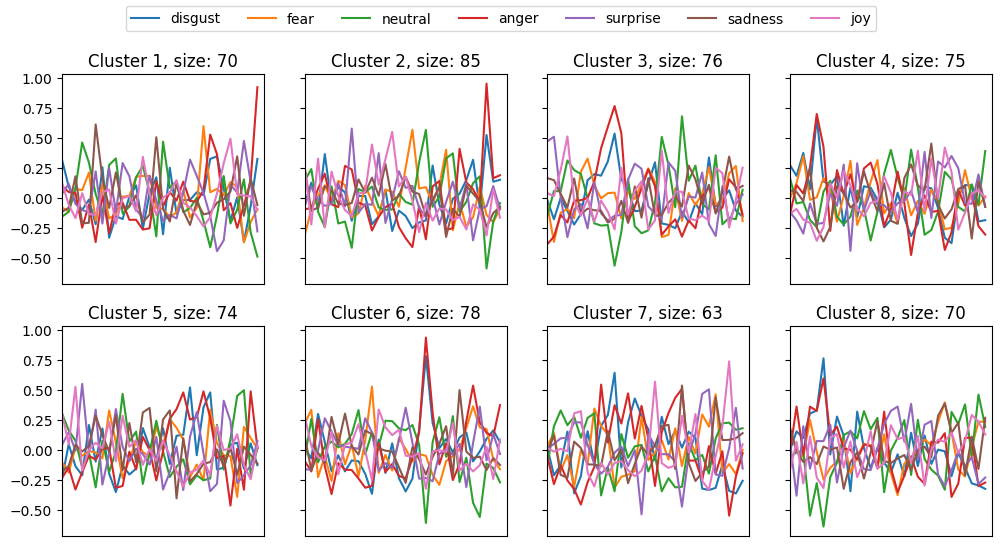

In [158]:
def plot_clusters(X, y_pred, centers):
    sz = X.shape[1]
    fig, _ = plt.subplots(2, 4, sharey=True, figsize=(12, 6))
    labels = None

    for yi in range(n_clusters):
        ax = plt.subplot(2, 4, yi + 1)
        for sentiment_i in range(len(sentiments)):
            plt.plot(centers[yi][:, sentiment_i:sentiment_i+1].ravel(), label=sentiments[sentiment_i])
        plt.xlim(0, sz)
        plt.xticks([])
        count = len(X[y_pred == yi])
        ax.set_title('Cluster {}, size: {}'.format(yi+1, count))
        if yi == 0:
            _, labels = ax.get_legend_handles_labels()

    fig.legend(labels=labels, loc="upper center", ncols=len(sentiments))

plot_clusters(ts_train_set_rs_1, y_pred, km.cluster_centers_)

קיבלנו מקבצים בגודל די זהה, וניתן לראות כי התקבלו מקבצים עם מאפיינים ייחודיים כמו עלייה בכעס וגועל במקבץ 6 באמצע הסרט, עליה בשמחה במקבץ 7 בסוף הסרט ועוד.

כעת ננסה לבחון עד כמה הcenterים תואמים את הנתונים המתאימים להם. ניקח לדוגמה את אחד הקלאסטרים, 6, ונציג אותו ביחד עם הנתונים שלו: 

In [159]:
def plot_cluster(X, km, yi, y_pred):
    plt.figure(figsize=(9,6))
    sz = X.shape[1]
    for sentiment_i in range(len(sentiments)):
        ax = plt.subplot(3, 3, sentiment_i + 1)
        for xx in X[y_pred == yi][:, :, sentiment_i:sentiment_i+1]:
            plt.plot(xx.ravel(), "k-", alpha=.1)
        plt.plot(km.cluster_centers_[yi][:, sentiment_i:sentiment_i+1].ravel(), "r-")
        plt.xlim(0, sz)
        plt.xticks([])
        ax.set_title(sentiments[sentiment_i].capitalize())

    plt.tight_layout()

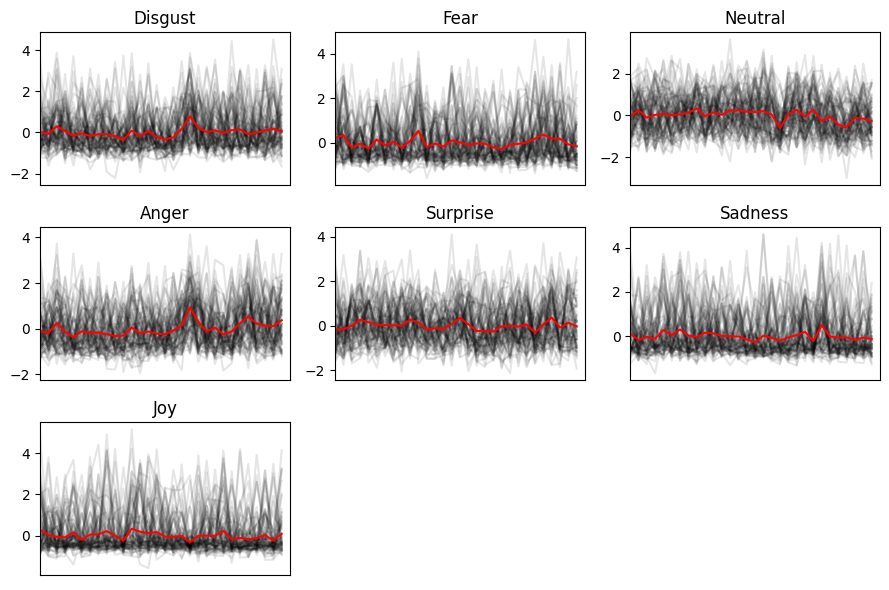

In [160]:
plot_cluster(ts_train_set_rs_1, km, 5, y_pred)

דבר ראשון שאפשר לשים לב בגרפים לעיל הוא שהcenterים בעלי אמפליטודה קטנה בהרבה מרוב הנתונים, מה שאומר שהcenterים הם ממוצע עם סטיית תקן יחסית גבוהה.
באופן כללי נראה שהאלגוריתם הצליח למצוא תבניות למשל בסנטימנטים כעס, גועל וניטרליות, לעומת סנטימטים אחרים שבהם אין כל כך אחידות בנתונים. בסך הכל התוצאות של המקבצים הן סבירות, אך לא ממש מדויקות והיינו רוצים לשפר אותן.

תובנה אחת שניתן לעלות היא כי האלגוריתם K-Means הפשוט מחפש עליות וירידות משותפות בסנטימנטים שנמצאות באותן נקודות בזמן, אך ייתכן וחיפוש זה הוא לא נכון, כיוון שאם לסרט יש מגמות משותפות לסרט אחר, אך בין הסרטים יש סטייה של כמה דיאלוגים, או שהסנטימנטים משתנים במהירויות שונות, עדיין אנו צריכים להחשיב את שניהם כדומים אחד לשני. לפיכך השוואה בין סרטים רק על פי נקודות זמן בודדות לא ייתן מענה מתאים.

למזלנו גם לבעה זו קיים פתרון בצרות האלגוריתם [DTW (Dynamic time warping)](https://www.wikiwand.com/en/Dynamic_time_warping) שעוזר לחשב דמיון בין Time Series גם כאשר בין הסדרות יש הבדלי זמנים. ניתן להשתמש באלגוריתם זה כפרמטר לאלגוריתם K-Means, וספציפית ב-tslearn נבחר להשתמש בוריאנט DBA (Dynamic Time Warping Barycenter Averaging):

In [86]:
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           n_init=3,
                           metric="dtw",
                           max_iter_barycenter=10,
                           random_state=0)
y_pred_dba = dba_km.fit_predict(ts_train_set_rs_1)

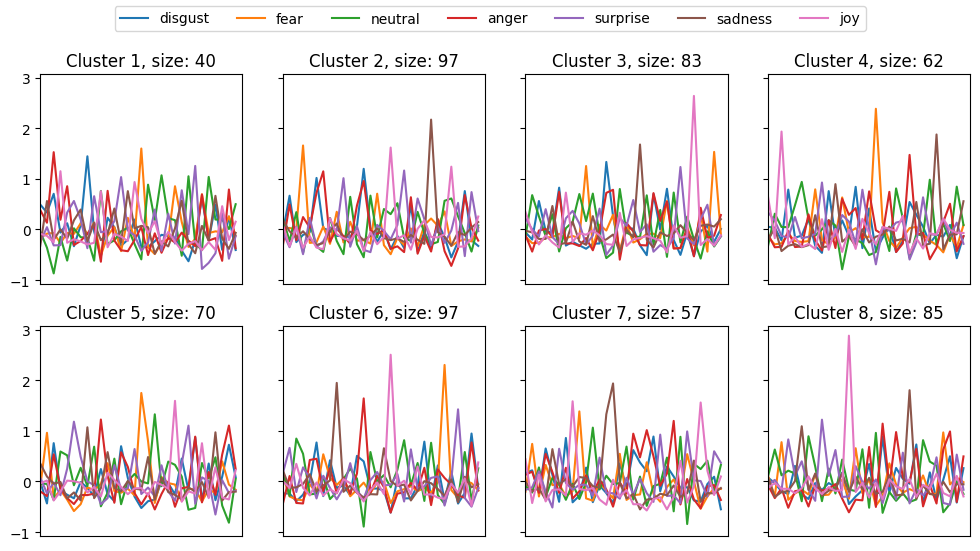

In [161]:
plot_clusters(ts_train_set_rs_1, y_pred_dba, dba_km.cluster_centers_)

ממבט ראשון אנו רואים כי האמפליטודות של הcenters גדלו באופן משמעותי, מה שמבציע על סטיית תקן יותר קטנה, ולפיכך תוצאות יותר מדויקות. נבחן את אחד הקלאסטרים: 

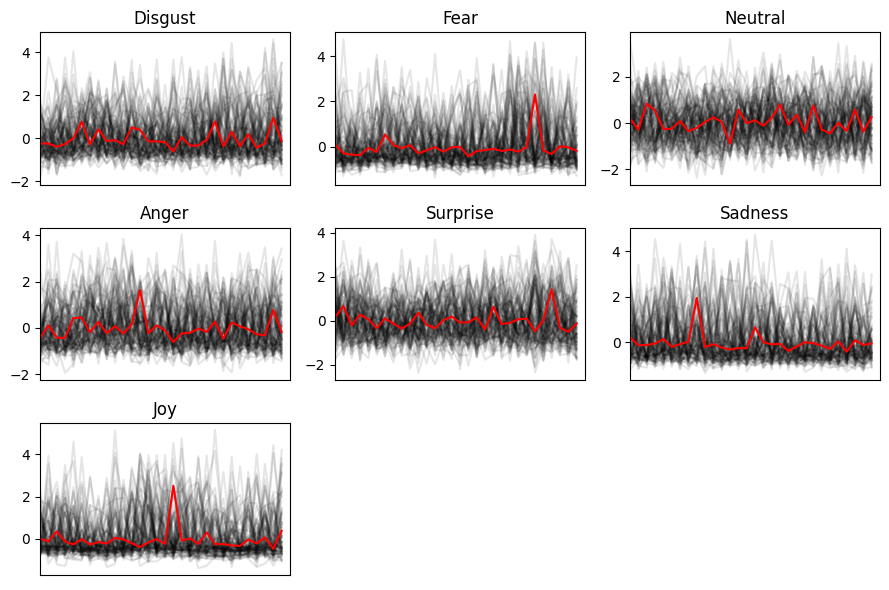

In [162]:
plot_cluster(ts_train_set_rs_1, dba_km, 5, y_pred_dba)

אנו יכולים לראות למשל עבור הסנטימנט פחד, האלגוריתם זיהה סרטים משותפים בהם חלה עליה בפחד במהלך סוף הסרט, וכן עבור הסנטימנט שמחה נראה כי זוהתה עליה באיזור אמצע הסרט. מצד שני עדיין קיימים סנטימנטים עבורם לא נראה שנמצאה תבנית ברורה, כמו גועל למשל. עובדה זו לא מפתיעה עד כדי כך, כיוון שגם בתוך ז'אנר מסוים, יכולים להיות כמה וריאציות.

ננתח את הקלאסטרים שקיבלנו כפי שעשינו בקלאסטרים הקודמים:

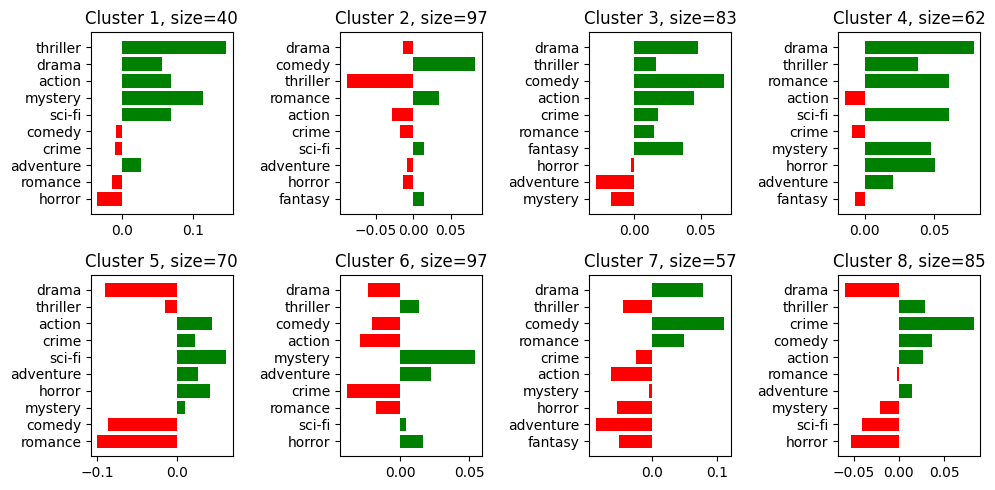

In [163]:
plt.figure(figsize=(10, 5))
           
for i in range(n_clusters):
    ax = plt.subplot(2, 4, i+1)
    cluster_idx = [j for j in range(len(ts_train_set)) if y_pred_dba[j] == i]
    cluster_mids = ts_train_set_ids[cluster_idx]
    show_cluster_genre_diff(cluster_mids, ax, i)

plt.tight_layout()
plt.show()

קיבלנו תוצאות מעניינות: 
- נראה שבקלאסטר 6 למשל שהזכרנו יש העדפה לסרטי מסתורין, הרפתקה, מתח ואימה. עובדה זו מסתדרת היטב עם כך המגמות של הסנטימנטים שהקלאסטר שבחרנו מזוהה איתם, למשל עלייה של הרגשות "הפתעה" ו"פחד" בסוף הסרט.
- קלאסטר 3 למשל מכיל מגוון רחב של סוגי ז'אנרים, קומדיה, פעולה וגם דרמה. על פי הגרף של הcenterים של קלאסטר 3 נראה שהוא מאופיין ע"י עליה ברגש "שמחה" באיזור סוף הסרט. ייתכן ומשמעות העליה היא מאפיין של סוף שמח. 

## סיכום 

### תוצאות וכיוונים להמשך

#### סיווג ז'אנרים
כאשר ביצענו סיווג ז'אנרים המבוסס על למידה מפוקחת השתמשנו במודל למידה של RandomForest ואימנו אותו על המידע הסנטימנטלי הממוצע של הסרטים. קיבלנו תוצאה של percision ממוצע (micro) של 0.5 לעומת recall ממוצע (micro) של 0.4. התוצאה היא סבירה יחסית לסיווג multi-label, אך לא מספיק כדי להסתמך עליו כמסווג מדויק, מכיוון שמספר השגיאות הוא גבוה. כמו כן ראינו כי שימוש במודל NB לא שיפר את התוצאה במידה משמעותית. 

כאשר בחנו את תהליך ההחלטה של המודל בעזרת explainer, ראינו דוגמה לשגיאת FN ושגיאת FP בהן הז'אנרים דרמה ופעולה לא סווגו נכון בגלל כלליות הז'אנרים הללו ודו-המשמעות של ערכי הסנטימנטים. כמו כן ראינו כי במקרה הספציפי הזה הז'אנר המרכזי של הסרט לא נלקח בחשבון. לכן ייתכן וחלק משגיאות הFN נובעות בצדק מחוסר התאמה מספיקה של הסנטינטים בסרטים לסנטימנטים של הז'אנר באופן כללי שאותם המודל למד, וייתכן כי בכל ז'אנר קיימות וריאציות עדינות שהמודל לא תפס. כמו כן ייתכן ושגיאות אלה נובעות מ-overfitting של המודל, והסנטימנטים שהמודל מצפה לראות הן רמות ספציפיות שנובעות מסט האימון. 

כדי לשפר את תוצאות המודל:
- ייתכן ואם נאמן מודל יותר מורכב כמו רשת נוירונים, נקבל מודל שיודע להתמודד יותר טוב עם הנתונים.
- מאגר הנתונים מכיל תיוגים של ז'אנרים שלפעמים מכיל ז'אנר אחד או 2 ולעתים יותר, וכל ז'אנר מתאים ברמה מסויימת. ייתכן כי במידה והתיוג היה מדויק יותר היינו משפרים את התוצאה.
- כמו כן, הרבה מהסרטים תויגו ללא ז'אנרים על ידי המודל, למרות שבפועל יש להם ז'אנרים. יכול להיות שאם נשתמש במודל שמחזיר ציון עבור כל ז'אנר במקום תיוגים בינאריים, כפי שקורה במודל הסנטימנטלי, ניתן יהיה לבחור את הז'אנרים המתאימים על פי הציונים הגבוהים.
- ניתן להשתמש בפיצ'רים אחרים מהסנטימנטים הממוצעים בסרט, כפי שבוצע עבור clustering, וכפי שיוזכר בהמשך

#### clustering 

בפרויקט ביצענו שני סוגי clustering - בעזרת פיצ'רים של המודל מ-🤗 ובעזרת Time Series. בשני המקרים קיבלנו קלאסטרים שאינם מתאימים באופן ישיר לאף ז'אנר ספציפי, אך מצאנו כי כל קלאסטר מכיל סרטים בעלי מאפיינים משותפים. במקרה של הפיצ'רים בעזרת הpipeline, השתמשנו ב-KMeans, ובקלאסטרים שקיבלנו מצאנו מאפיינים משותפים המתאימים לאופי הסנטימנטלי הכללי של כל סרט.

במקרה של Time Series גם ביצענו KMeans המותאם לTS, כאשר הרצת האלגוריתם המרחקים הרגיל ארכה כ-1s (עם n_init=3) והרצת האלגוריתם DTW ארכה כ-30s. מצד שני ראינו כי הרצת DTW משפרת משמעותית את הclustering ומאפשרת לקבץ יחד סרטים עם מגמות דומות בסנטימנטים עם הבדלים ב-offsetים. בקלאסטרים שקיבלנו מצאנו סרטים עם מאפיינים משותפים במגמות הסנטימטים לאורך הסרט.

#### חילוץ פיצ'רים מתקדם

הדרך הבסיסית שבה פתרנו את ריבוי הפיצ'רים לאורך הסרט היא בעזרת חישוב ממוצע של כל הדיאלוגים. דרך זו היא פשטנית למדי, וניתן לחשוב על דרכים אחרות שדרכן ניתן לחלץ את הפיצ'רים עבור כל סרט בצורה חכמה יותר:
- למשל התחשבות בכמות נק' השיא של כל סנטימנט, אורך ממוצע של כל שיא כזה ועוד.
- התייחסו לדמות שאמרה את השורה - מה ממוצע הסנטימנטים עבור כל דמות למשל
- במידה והמאגר היה מכיל timestamps עבור כל דיאלוג בסרט, ייתכן שבעזרת המידע הזה ניתן לקבל תובנות נוספות, וכן לשלב את הזמנים בניתוח Time Series שביצענו.
 

### clustering מול למידה מדוגמאות
במהלך הפרויקט ניתחנו טקסטים של מגוון סרטים באנגלית, חילצנו פיצ'רים המבוססים על המידע הטקסטואלי, וניסינו לסווג את הסרטים בעזרת פיצ'רים אלו, בעזרת למידה מפוקחת ובלתי מפוקחת. באופן כללי הבעיה של clustering בהקשר של ניתוח סנטימנטלי של סרטים היא יותר מעניינת לדעתי מאשר סיווג ז'אנרים, וזאת מכיוון שבclustering אין הנחה כי יש קשר הדוק בין הסנטימנטים של הסרט לבין הז'אנר שלו, אלא המשימה היא למצוא מכנה משותף. אמנם גם ז'אנר הוא סוג של מכנה משותף, אך לרוב מדובר על מאפיין כללי של הסרט שאינו מתאר באופן מדויק את תוכנו, ובדרך כלל ניתן להשוות בין סרטים רק אם יש להם יותר מז'אנר אחד משותף. כאשר מבצעים clustering אפשר למצוא "ז'אנרים חדשים" של סרטים על פי התוכן שלהם ולהגיע לתובנות מעניינות על השוני והדמיון בין סרטים. 

### movie-dialog-corpus
כיוון שהמאגר הגיע מkaggle היו לי ציפיות גבוהות לגביו בהתחלה, אך מהר מאוד הבנתי כי קיימים פערים משמעותיים בנתונים:
- שורות שאינן בפורמט המתאים, שורות ושיחות חסרות, בעיות בencoding, ועוד.
- הבדלים משמעותיים בכמות הז'אנרים לכל סרט כפי שהזכרנו, כך שלא היתה אחידות בתיוג.
- המאגר קצת מיושן ואינו מכיל סרטים אחרי 2010

ייתכן כי ניתן לשפר את התוצאות עם מידע חדש ומטויב יותר.

### חוויה אישית
מאוד נהניתי לעבוד על הפרוייקט כיוון שהנושא של ניתוח מידע טקסטואלי מעניין אותי במיוחד, וכן במהלך העבודה גיליתי תובנות חדשות על הסרטים שניתחתי, ולמדתי נושאים חדשים שלא הכרתי עד כדי כך, כמו multi-label classification, שימוש ב-pipeline של 🤗 ו-Time Series